# Part 2: Chr21 compartment analysis with transcription

by Pu Zheng and Jun-Han Su

2020.06.06

# Table of contents

>0. [Minimum required packages and settings](#0)
>>
>>0.1: [import required packages](#0.1)
>>
>>0.2: [parameters for plotting](#0.2)
>
>1. [Load data from deposited dataset](#1)
>>
>>1.1 [load chr21 replicate 1](#1.1)
>>
>>1.2 [load chr21 replicate 2](#1.2)
>>
>>1.3 [combine two datasets](#1.3)
>
>2. [Compartment analysis of chr21](#2)
>>
>>2.1 [generate imaging-based median distance and proximity frequency maps](#2.1)
>>
>>2.2 [load corresponding Hi-C map](#2.2)
>>
>>2.3 [call compartments](#2.3)
>
>3. [Analysis of A/B density in single-cells](#3)
>>
>>3.1 [calculate density scores](#3.1)
>>
>>3.2 [median density for chr21](#3.2)
>>
>>3.3 [visualize density in the example chromosome](#3.3)
>>
>>3.4 [calculate segregation scores based on A,B density](#3.4)
>>
>>3.5 [A/B density ratio difference w/wo transcription](#3.5)
>>
>>3.6 [firing rate difference with high/low A/B density ratio](#3.6)
>
>4. [Characterization of compartments in G1, G2/S cells](#4)
>>
>>4.1 [calculate A,B density scores for replicate 2](#4.1)
>>
>>4.2 [calculate segregation scores for G1,G2/S chromosomes](#4.2)


<a id='0'></a>
# 0. Minimum required packages and settings

<a id='0.1'></a>
## 0.1 import required packages

In [1]:
# imports
import os,sys
import numpy as np
import pickle

sys.path.append(os.path.abspath(os.path.join(r"..", r".")))

import source as ia

print(os.getpid()) # print this so u can terminate through cmd / task-manager

27936


<a id='0.2'></a>
## 0.2 parameters for plotting

In [2]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
_font_size = 7.5

In [3]:
# Required plotting parameters
from source.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size

In [4]:
# figure folder
# please specify location to save images
parent_figure_folder = os.path.abspath(os.path.join(r"..", r"..", r"..", r"2020_cell_figures"))
figure_folder = os.path.join(parent_figure_folder, 'Chr21_compartment_figures')
print(figure_folder)
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
    print("generating this folder")

E:\Users\puzheng\Documents\2020_cell_figures\Chr21_compartment_figures
generating this folder


<a id='1'></a>
# 1. Load data from deposited dataset

Please visit zenodo with DOI:10.5281/zenodo.3928890

In [5]:
# please change data_folder into the folder for downloaded dataset
data_folder = os.path.abspath(os.path.join(r"..", r"..", r"..", r"2020_cell_data"))
print(f"data_folder: {data_folder}")
rep1_filename = os.path.join(data_folder, 'chromosome21.tsv')
rep2_filename = os.path.join(data_folder, 'chromosome21-cell_cycle.tsv')

print(os.path.isfile(rep1_filename), os.path.isfile(rep1_filename))

data_folder: E:\Users\puzheng\Documents\2020_cell_data
True True


<a id='1.1'></a>
## 1.1 load chr21 replicate 1 

(without cell cycle information)

In [6]:
from tqdm import tqdm_notebook as tqdm

# load from file and extract info
import csv
rep1_info_dict = {}
with open(rep1_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    _headers = next(_reader)
    print(_headers)
    # create keys for each header
    for _h in _headers:
        rep1_info_dict[_h] = []
    # loop through content
    for _contents in _reader:
        for _h, _info in zip(_headers,_contents):
            rep1_info_dict[_h].append(_info)

# clean up information
data_rep1 = {'params':{}}

# clean up genomic coordiantes
region_names = np.array([_n for _n in sorted(np.unique(rep1_info_dict['Genomic coordinate']), 
                                             key=lambda s:int(s.split(':')[1].split('-')[0]))])
region_starts = np.array([int(_n.split(':')[1].split('-')[0]) for _n in region_names])
region_ends = np.array([int(_n.split(':')[1].split('-')[1]) for _n in region_names])[np.argsort(region_starts)]
region_starts = np.sort(region_starts)

mid_positions = ((region_starts + region_ends)/2).astype(np.int)
mid_positions_Mb = np.round(mid_positions / 1e6, 2) 
start_position_Mb = np.round(region_starts / 1e6, 2) 
end_position_Mb = np.round(region_ends / 1e6, 2) 

# clean up chrom copy number
chr_nums = np.array([int(_info) for _info in rep1_info_dict['Chromosome copy number']])
chr_ids, region_cts = np.unique(chr_nums, return_counts=True)
dna_zxys_list = [[[] for _start in region_starts] for _id in chr_ids]

# clean up zxy
for _z,_x,_y,_reg_info, _cid in tqdm(zip(rep1_info_dict['Z(nm)'],rep1_info_dict['X(nm)'],\
                                         rep1_info_dict['Y(nm)'],rep1_info_dict['Genomic coordinate'],\
                                         rep1_info_dict['Chromosome copy number'])):
    # get chromosome inds
    _cid = int(_cid)
    _cind = np.where(chr_ids == _cid)[0][0]
    
    # get region indices
    _start = int(_reg_info.split(':')[1].split('-')[0])
    _rind = np.where(region_starts==_start)[0][0]
    
    dna_zxys_list[_cind][_rind] = np.array([float(_z),float(_x), float(_y)])

# merge together
dna_zxys_list = np.array(dna_zxys_list)
data_rep1['chrom_ids'] = chr_ids
data_rep1['region_names'] = region_names
data_rep1['mid_position_Mb'] = mid_positions_Mb
data_rep1['start_position_Mb'] = start_position_Mb
data_rep1['end_position_Mb'] = end_position_Mb
data_rep1['dna_zxys'] = dna_zxys_list

# clean up tss and transcription
if 'Gene names' in rep1_info_dict:
    import re
    # first extract number of genes
    gene_names = []
    for _gene_info, _trans_info, _tss_coord in zip(rep1_info_dict['Gene names'],
                                                   rep1_info_dict['Transcription'],
                                                   rep1_info_dict['TSS ZXY(nm)']):
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            for _gene in _genes:
                if _gene not in gene_names:
                    gene_names.append(_gene)
    print(f"{len(gene_names)} genes exist in this dataset.")
    
    # initialize gene and transcription
    tss_zxys_list = [[[] for _gene in gene_names] for _id in chr_ids]
    transcription_profiles = [[[] for _gene in gene_names] for _id in chr_ids]
    # loop through to get info
    for _cid, _gene_info, _trans_info, _tss_locations in tqdm(zip(rep1_info_dict['Chromosome copy number'],
                                                                  rep1_info_dict['Gene names'],
                                                                  rep1_info_dict['Transcription'],
                                                                  rep1_info_dict['TSS ZXY(nm)'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        # process if there are genes in this region:
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            _transcribes = _trans_info.split(';')[:-1]
            _tss_zxys = _tss_locations.split(';')[:-1]
            for _gene, _transcribe, _tss_zxy in zip(_genes, _transcribes, _tss_zxys):
                # get gene index
                _gind = gene_names.index(_gene)
                # get transcription profile
                if _transcribe == 'on':
                    transcription_profiles[_cind][_gind] = True
                else:
                    transcription_profiles[_cind][_gind] = False
                # get coordinates
                _tss_zxy = np.array([np.float(_c) for _c in re.split(r'\s+', _tss_zxy.split('[')[1].split(']')[0]) if _c != ''])
                tss_zxys_list[_cind][_gind] = _tss_zxy
                
    tss_zxys_list = np.array(tss_zxys_list)
    transcription_profiles = np.array(transcription_profiles)
    data_rep1['gene_names'] = gene_names
    data_rep1['tss_zxys'] = tss_zxys_list
    data_rep1['trans_pfs'] = transcription_profiles

# clean up cell_cycle states
if 'Cell cycle state' in rep1_info_dict:
    cell_cycle_types = np.unique(rep1_info_dict['Cell cycle state'])
    cell_cycle_flag_dict = {_k:[[] for _id in chr_ids] for _k in cell_cycle_types if _k != 'ND'}
    for _cid, _state in tqdm(zip(rep1_info_dict['Chromosome copy number'],rep1_info_dict['Cell cycle state'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        if np.array([_v[_cind]==[] for _k,_v in cell_cycle_flag_dict.items()]).any():
            for _k,_v in cell_cycle_flag_dict.items():
                if _k == _state:
                    _v[_cind] = True
                else:
                    _v[_cind] = False
    # append to data
    for _k, _v in cell_cycle_flag_dict.items():
        data_rep1[f'{_k}_flags'] = np.array(_v)  

['Z(nm)', 'X(nm)', 'Y(nm)', 'Genomic coordinate', 'Chromosome copy number', 'Gene names', 'Transcription', 'TSS ZXY(nm)']



84 genes exist in this dataset.


<a id='1.2'></a>
## 1.2 load chr21 replicate 2 

(with cell cycle information)

In [7]:
from tqdm import tqdm_notebook as tqdm

# load from file and extract info
import csv
rep2_info_dict = {}
with open(rep2_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    _headers = next(_reader)
    print(_headers)
    # create keys for each header
    for _h in _headers:
        rep2_info_dict[_h] = []
    # loop through content
    for _contents in _reader:
        for _h, _info in zip(_headers,_contents):
            rep2_info_dict[_h].append(_info)

# clean up information
data_rep2 = {'params':{}}

# clean up genomic coordiantes
region_names = np.array([_n for _n in sorted(np.unique(rep2_info_dict['Genomic coordinate']), 
                                             key=lambda s:int(s.split(':')[1].split('-')[0]))])
region_starts = np.array([int(_n.split(':')[1].split('-')[0]) for _n in region_names])
region_ends = np.array([int(_n.split(':')[1].split('-')[1]) for _n in region_names])[np.argsort(region_starts)]
region_starts = np.sort(region_starts)

mid_positions = ((region_starts + region_ends)/2).astype(np.int)
mid_positions_Mb = np.round(mid_positions / 1e6, 2) 
start_position_Mb = np.round(region_starts / 1e6, 2) 
end_position_Mb = np.round(region_ends / 1e6, 2) 

# clean up chrom copy number
chr_nums = np.array([int(_info) for _info in rep2_info_dict['Chromosome copy number']])
chr_ids, region_cts = np.unique(chr_nums, return_counts=True)
dna_zxys_list = [[[] for _start in region_starts] for _id in chr_ids]

# clean up zxy
for _z,_x,_y,_reg_info, _cid in tqdm(zip(rep2_info_dict['Z(nm)'],rep2_info_dict['X(nm)'],\
                                         rep2_info_dict['Y(nm)'],rep2_info_dict['Genomic coordinate'],\
                                         rep2_info_dict['Chromosome copy number'])):
    # get chromosome inds
    _cid = int(_cid)
    _cind = np.where(chr_ids == _cid)[0][0]
    
    # get region indices
    _start = int(_reg_info.split(':')[1].split('-')[0])
    _rind = np.where(region_starts==_start)[0][0]
    
    dna_zxys_list[_cind][_rind] = np.array([float(_z),float(_x), float(_y)])

# merge together
dna_zxys_list = np.array(dna_zxys_list)
data_rep2['chrom_ids'] = chr_ids
data_rep2['region_names'] = region_names
data_rep2['mid_position_Mb'] = mid_positions_Mb
data_rep2['start_position_Mb'] = start_position_Mb
data_rep2['end_position_Mb'] = end_position_Mb
data_rep2['dna_zxys'] = dna_zxys_list

# clean up tss and transcription
if 'Gene names' in rep2_info_dict:
    import re
    # first extract number of genes
    gene_names = []
    for _gene_info, _trans_info, _tss_coord in zip(rep2_info_dict['Gene names'],
                                                   rep2_info_dict['Transcription'],
                                                   rep2_info_dict['TSS ZXY(nm)']):
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            for _gene in _genes:
                if _gene not in gene_names:
                    gene_names.append(_gene)
    print(f"{len(gene_names)} genes exist in this dataset.")
    
    # initialize gene and transcription
    tss_zxys_list = [[[] for _gene in gene_names] for _id in chr_ids]
    transcription_profiles = [[[] for _gene in gene_names] for _id in chr_ids]
    # loop through to get info
    for _cid, _gene_info, _trans_info, _tss_locations in tqdm(zip(rep2_info_dict['Chromosome copy number'],
                                                                  rep2_info_dict['Gene names'],
                                                                  rep2_info_dict['Transcription'],
                                                                  rep2_info_dict['TSS ZXY(nm)'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        # process if there are genes in this region:
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            _transcribes = _trans_info.split(';')[:-1]
            _tss_zxys = _tss_locations.split(';')[:-1]
            for _gene, _transcribe, _tss_zxy in zip(_genes, _transcribes, _tss_zxys):
                # get gene index
                _gind = gene_names.index(_gene)
                # get transcription profile
                if _transcribe == 'on':
                    transcription_profiles[_cind][_gind] = True
                else:
                    transcription_profiles[_cind][_gind] = False
                # get coordinates
                _tss_zxy = np.array([np.float(_c) for _c in re.split(r'\s+', _tss_zxy.split('[')[1].split(']')[0]) if _c != ''])
                tss_zxys_list[_cind][_gind] = _tss_zxy
                
    tss_zxys_list = np.array(tss_zxys_list)
    transcription_profiles = np.array(transcription_profiles)
    data_rep2['gene_names'] = gene_names
    data_rep2['tss_zxys'] = tss_zxys_list
    data_rep2['trans_pfs'] = transcription_profiles

# clean up cell_cycle states
if 'Cell cycle state' in rep2_info_dict:
    cell_cycle_types = np.unique(rep2_info_dict['Cell cycle state'])
    cell_cycle_flag_dict = {_k:[[] for _id in chr_ids] for _k in cell_cycle_types if _k != 'ND'}
    for _cid, _state in tqdm(zip(rep2_info_dict['Chromosome copy number'],rep2_info_dict['Cell cycle state'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        if np.array([_v[_cind]==[] for _k,_v in cell_cycle_flag_dict.items()]).any():
            for _k,_v in cell_cycle_flag_dict.items():
                if _k == _state:
                    _v[_cind] = True
                else:
                    _v[_cind] = False
    # append to data
    for _k, _v in cell_cycle_flag_dict.items():
        data_rep2[f'{_k}_flags'] = np.array(_v)  

['Z(nm)', 'X(nm)', 'Y(nm)', 'Genomic coordinate', 'Chromosome copy number', 'Gene names', 'Transcription', 'TSS ZXY(nm)', 'Cell cycle state']



84 genes exist in this dataset.


<a id='1.3'></a>
## 1.3 combine two datasets

in most of panels we combined chromosomes from two replicates for better statistics

In [8]:
data_combined = {}
for _k in data_rep1:
    if _k in data_rep2:
        # concatenate if this is some chromosomal data
        if len(data_rep1[_k]) == len(data_rep1["chrom_ids"]):
            data_combined[_k] = np.concatenate([data_rep1[_k],data_rep2[_k]])
        # directly merge if this is some shared information
        elif (np.array(data_rep1[_k]) == np.array(data_rep2[_k])).all():
            data_combined[_k] = data_rep1[_k]
            
print('Number of chromosomes:', len(data_combined['chrom_ids']))

Number of chromosomes: 12149


<a id='2'></a>
# 2. Compartment analysis of chr21

<a id='2.1'></a>
## 2.1 generate imaging-based median distance and proximity frequency maps

In [9]:
from scipy.spatial.distance import pdist, squareform
zxys_combined_list = np.array(data_combined['dna_zxys'])
distmap_combined_list = np.array([squareform(pdist(_zxy)) for _zxy in tqdm(zxys_combined_list)])

# generate median distance map
median_distance_map_combined = np.nanmedian(distmap_combined_list, axis = 0)
# generate contact map
contact_th = 500
contact_map_combined = np.sum(distmap_combined_list<contact_th, axis=0) / np.sum(np.isnan(distmap_combined_list)==False, axis=0)# load Hi-C

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


<a id='2.2'></a>
## 2.2 load corresponding Hi-C map 

from: *Rao et al., 2014* 

A cleaned version of contact matrix for corresponding genomic regions is saved into the provided dataset as well.

In [10]:
# load Hi-C
hic_filename = os.path.join(data_folder, 'Hi-C matrices', 'Hi-C_contacts_chromosome21.tsv')

hic_raw_map = []

with open(hic_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    col_regions = next(_reader)[1:]
    row_regions = []
    # loop through content
    for _contents in _reader:
        row_regions.append(_contents[0])
        hic_raw_map.append([float(_c) for _c in _contents[1:]])
hic_raw_map = np.array(hic_raw_map)
# sort row and col to match tsv dataset
row_order = np.concatenate([np.where(data_rep1['region_names']==_rn)[0] for _rn in row_regions])
col_order = np.concatenate([np.where(data_rep1['region_names']==_cn)[0] for _cn in col_regions])
hic_raw_map = hic_raw_map[row_order][:, col_order]

<a id='2.3'></a>
## 2.3 call compartments

1. remove genomic effect by log-log linear regression between contact/hic map with genomic distance map and normalize with it
2. calculate correlation map
3. do PCA, use PC1 as AB calling
4. merge very small compartment fragments for calling robustness

(FigS2A, Fig2A)

<a id='2.3.1'></a>
### 2.3.1 calculate and plot PC1

(FigS2A)

In [11]:
from scipy.stats import linregress
## compartment calling by PCA

#for contact_gaussian_sigma in np.arange(0,3,0.03):
# Generate correlation map
contact_gaussian_sigma = 1.9
hic_gaussian_sigma = 1.9
# normalize genomic distance effects
genomic_distance_map = squareform(pdist(data_combined['mid_position_Mb'][:,np.newaxis]))
genomic_distance_entries = genomic_distance_map[np.triu_indices(len(genomic_distance_map),1)]

# normalize genomic distance effects
contact_entries = contact_map_combined[np.triu_indices(len(contact_map_combined
                                                      ),1)]
kept = (genomic_distance_entries > 0) * (contact_entries > 0)
contact_lr = linregress(np.log(genomic_distance_entries[kept]), np.log(contact_entries[kept]))
#print(contact_lr)
contact_norm_map = np.exp(np.log(genomic_distance_map) * contact_lr.slope + contact_lr.intercept)
#for _i in range(len(normalization_mat)):
#    contact_norm_map[_i,_i] = 1
contact_normed_map = contact_map_combined / contact_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

contact_corr_map_combined = np.corrcoef(gaussian_filter(contact_normed_map, contact_gaussian_sigma))

# normalize genomic distance effects
hic_entries = hic_raw_map[np.triu_indices(len(hic_raw_map),1)]
kept = (genomic_distance_entries > 0) * (hic_entries > 0)
hic_lr = linregress(np.log(genomic_distance_entries[kept]), np.log(hic_entries[kept]))
#print(hic_lr)
hic_norm_map = np.exp(np.log(genomic_distance_map) * hic_lr.slope + hic_lr.intercept)
#for _i in range(len(normalization_mat)):
#    hic_norm_map[_i,_i] = 1
hic_normed_map = hic_raw_map / hic_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

hic_corr_map = np.corrcoef(gaussian_filter(hic_normed_map, hic_gaussian_sigma))

# Do PCA
from sklearn.decomposition import PCA
contact_model = PCA(1)
contact_model.fit(contact_corr_map_combined)
contact_pc1_combined = np.reshape(contact_model.fit_transform(contact_corr_map_combined), -1)

hic_model = PCA(1)
hic_model.fit(hic_corr_map)
hic_pc1 = np.reshape(hic_model.fit_transform(hic_corr_map), -1)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log


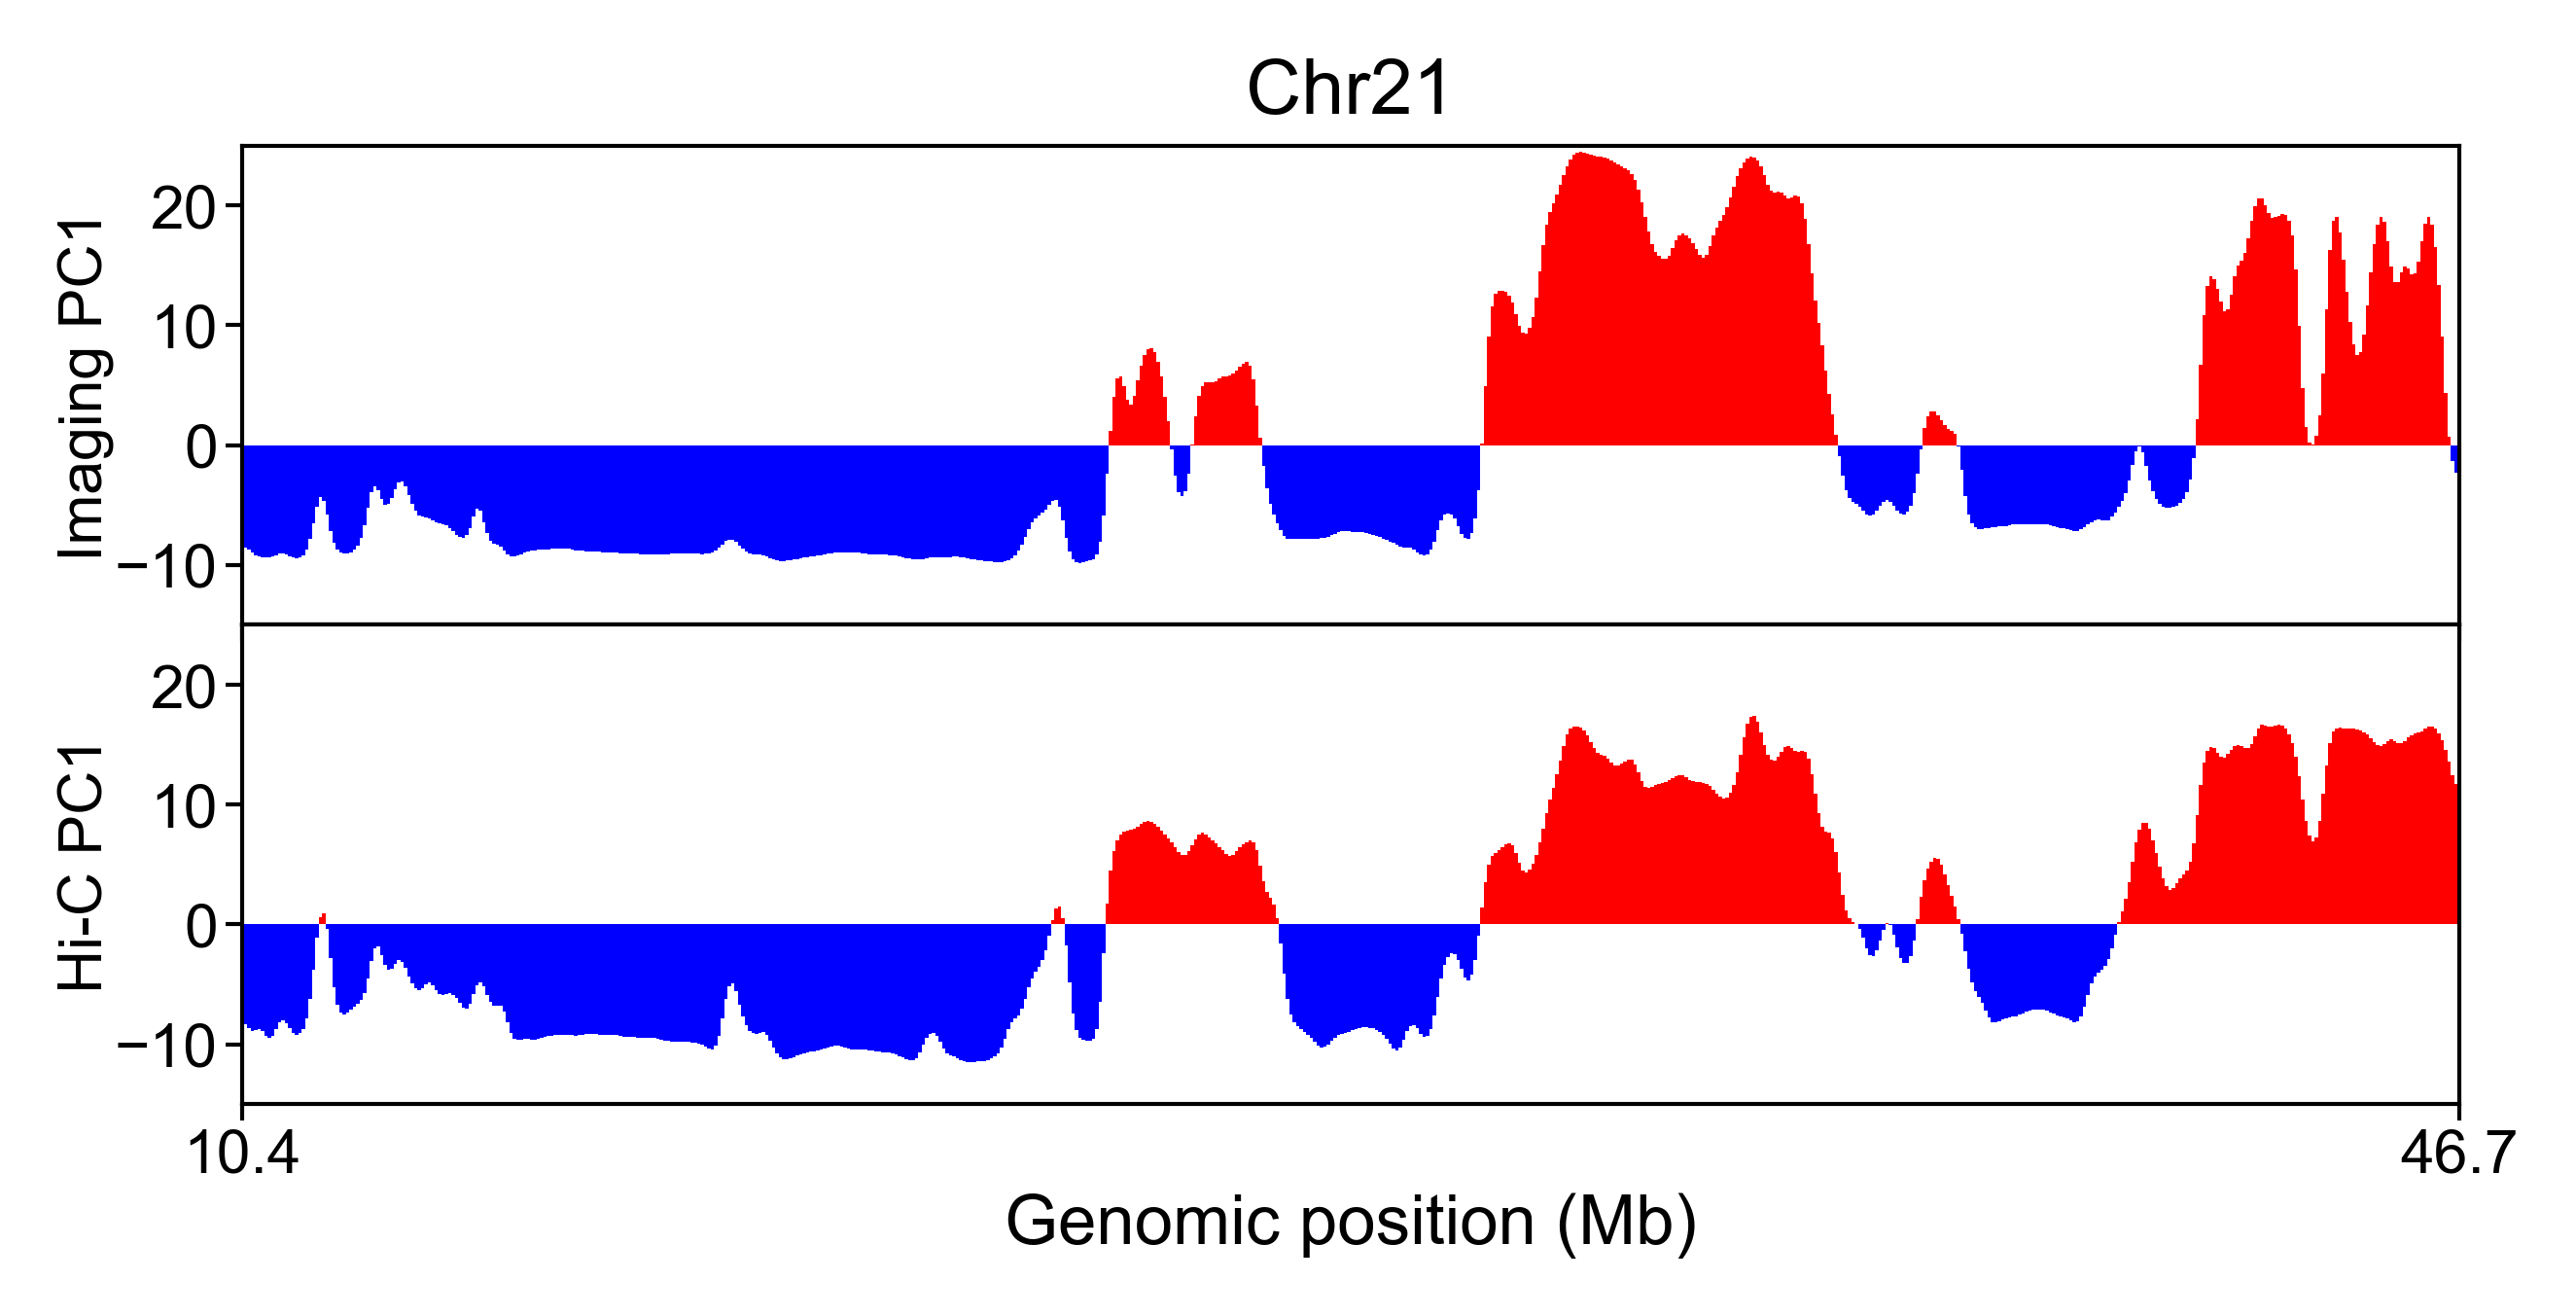

In [12]:
## pc1 barplot
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width), dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[1,1], hspace=0., wspace=0.)
contact_ax = plt.subplot(grid[0])
contact_ax.bar(np.where(contact_pc1_combined>=0)[0],
               contact_pc1_combined[contact_pc1_combined>=0],
               width=1, color='r', label='A')
contact_ax.bar(np.where(contact_pc1_combined<0)[0],
               contact_pc1_combined[contact_pc1_combined<0],
               width=1, color='b', label='B')
contact_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in contact_ax.spines.items()]
contact_ax.set_ylim([-15,25])
contact_ax.set_yticks([-10,0,10,20])
contact_ax.set_ylabel("Imaging PC1", fontsize=_font_size, labelpad=0)

contact_ax.set_title('Chr21', fontsize=_font_size+2, pad=4)
# hic-ax
hic_ax = plt.subplot(grid[1], sharex=contact_ax)

hic_ax.bar(np.where(hic_pc1>=0)[0],
               hic_pc1[hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(hic_pc1<0)[0],
               hic_pc1[hic_pc1<0],
               width=1, color='b', label='B')
hic_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in hic_ax.spines.items()]
hic_ax.set_ylim([-15,25])
hic_ax.set_yticks([-10,0,10,20])
hic_ax.set_ylabel("Hi-C PC1", fontsize=_font_size, labelpad=0)

# set x limits
hic_ax.set_xlim([0, len(contact_pc1_combined)])
# set x ticks
_xticks = [0, len(contact_pc1_combined)]
_xticklabels =  [data_combined['start_position_Mb'][0],
                 data_combined['end_position_Mb'][-1],] 

hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(_xticklabels)
hic_ax.set_xlabel(f'Genomic position (Mb)', fontsize=_font_size+1, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'FigS2A_chr21_PC1_barplot_combined.pdf'), transparent=True)

plt.show()

<a id='2.3.2'></a>
### 2.3.2 further merge small domains and save compartments

In [13]:
# define AB compartment by merging small sub-compartments
min_comp_size = 7 # allowed minimum sub-compartment size

temp_AB_dict = {'A':np.where(contact_pc1_combined >= 0)[0],
                'B':np.where(contact_pc1_combined < 0)[0],}

temp_AB_vector = np.ones(len(zxys_combined_list[0])).astype(np.int) * -1
temp_AB_vector[temp_AB_dict['A']] = 1
temp_AB_vector[temp_AB_dict['B']] = 0

num_small_compartment = np.inf
prev_v = temp_AB_vector[0]
while num_small_compartment > 0:
    # find indices for all sub-comaprtments
    all_comp_inds = []
    _comp_inds = []
    prev_v = temp_AB_vector[0] # initialize previous compartment
    for _i, _v in enumerate(temp_AB_vector):
        if prev_v != _v:
            all_comp_inds.append(_comp_inds)
            _comp_inds = [_i]
        else:
            _comp_inds.append(_i)            
        prev_v = _v
    if _comp_inds != []:
        all_comp_inds.append(_comp_inds)
    # calculate length of each compartment
    all_comp_lens = np.array([len(_c) for _c in all_comp_inds])
    # update number of small comparment
    num_small_compartment = np.sum(all_comp_lens < min_comp_size)
    # choose the smallest compartment to flip its AB
    if num_small_compartment > 0:
        print(all_comp_lens, num_small_compartment)
        flip_ind = np.argmin(all_comp_lens)
        temp_AB_vector[np.array(all_comp_inds[flip_ind])] = 1 - temp_AB_vector[np.array(all_comp_inds[flip_ind])]

# based on this cleaned AB_vector, recreate AB_dict
data_combined['AB_dict'] = {
    'A': np.where(temp_AB_vector==1)[0],
    'B': np.where(temp_AB_vector==0)[0],
}

[255  18   6  21  64 105  25  10  70  75   2] 2
[255  18   6  21  64 105  25  10  70  77] 1


In [14]:
pickle.dump(data_combined['AB_dict'], 
            open(os.path.join(data_folder, f'chr21_combined_AB_dict_{contact_gaussian_sigma}.pkl'), 'wb'))

<a id='2.3.3'></a>
### 2.3.3 plot correlation map with AB calling

(Fig2A)

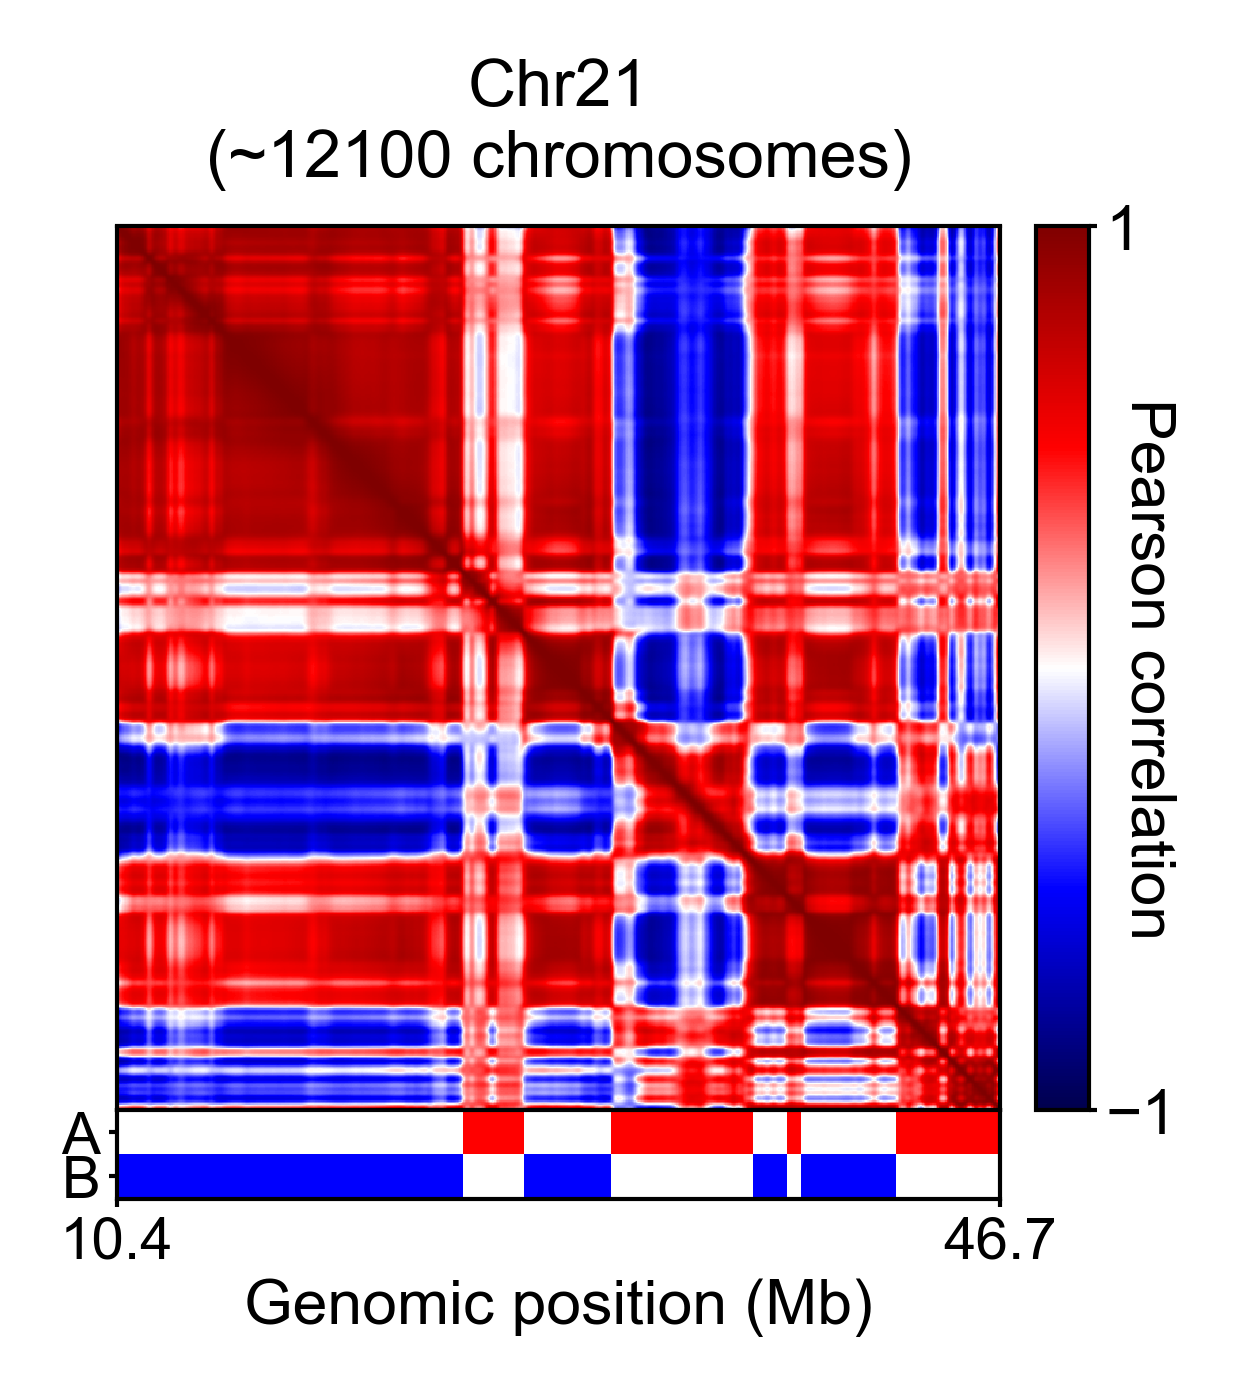

In [108]:
lims = [0,len(contact_corr_map_combined)]

xlims = np.array([min(lims), max(lims)])
ylims = np.array([min(lims), max(lims)])

from mpl_toolkits.axes_grid1 import make_axes_locatable

domain_line_color = [1,1,0,1]
domain_line_width = 1.5
bad_color=[0,0,0,1]

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)

# create a color map
current_cmap = matplotlib.cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

_pf = ax1.imshow(contact_corr_map_combined, cmap=current_cmap, vmin=-1, vmax=1)

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[-1,1])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(data_combined['AB_dict']['A'], height=1, color='r', width=1, label='A')
bot_ax.bar(data_combined['AB_dict']['B'], height=-1, color='b', width=1, label='B')
bot_ax.set_yticks([])
bot_ax.set_yticklabels([])
bot_ax.set_ylim([-1,1])
bot_ax.set_yticks([0.5,-0.5])
bot_ax.set_yticklabels(["A","B"])

_xticks = [-0.5, len(contact_corr_map_combined)-0.5]
_xticklabels =  [data_combined['start_position_Mb'][0],
                 data_combined['end_position_Mb'][-1],] 

bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(_xticklabels)
# tick params
bot_ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]
# set labels
bot_ax.set_xlabel(f'Genomic position (Mb)', fontsize=_font_size, labelpad=1)

# set limits
bot_ax.set_xlim(xlims-0.5)

ax1.set_title(f"Chr21\n(~{np.round(len(data_combined['chrom_ids']),-2)} chromosomes)", fontsize=_font_size+0.5)

# save
plt.gcf().subplots_adjust(bottom=0.15, left=0.16, right=0.88)

plt.savefig(os.path.join(figure_folder, f'Fig2A_chr21_contact_corr_map_combined.pdf'), transparent=True)

plt.show()

<a id='3'></a>
# 3. Analysis of A/B density in single-cells

<a id='3.1'></a>
## 3.1 calculate density scores

by placing gaussian pdf at the coordinates of genomic regions

In [15]:
import multiprocessing as mp
import time
num_threads=32
density_var = 108 # nm
overwrite=True

# density score for 50kb genomic regions
_dna_density_args = [(_zxys,_zxys, data_combined['AB_dict'], [density_var,density_var,density_var], True) 
                     for _zxys in data_combined['dna_zxys']]
_dna_density_time = time.time()

print(f"Multiprocessing calculate dna_density_scores", end=' ')
if 'dna_density_scores' not in data_combined or overwrite:
    with mp.Pool(num_threads) as dna_density_pool:
        dna_density_dicts = dna_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _dna_density_args)
        dna_density_pool.close()
        dna_density_pool.join()
        dna_density_pool.terminate()
    # save
    data_combined['dna_density_scores'] = dna_density_dicts
print(f"in {time.time()-_dna_density_time:.3f}s.")

# density score for tss
_gene_density_args = [(_gzxys,_zxys, data_combined['AB_dict'], [density_var,density_var,density_var], True) 
                     for _gzxys, _zxys in zip(data_combined['tss_zxys'], data_combined['dna_zxys']) ]
_gene_density_time = time.time()

print(f"Multiprocessing calculate gene_density_scores", end=' ')
if 'gene_density_scores' not in data_combined or overwrite:
    with mp.Pool(num_threads) as gene_density_pool:
        gene_density_dicts = gene_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _gene_density_args)
        gene_density_pool.close()
        gene_density_pool.join()
        gene_density_pool.terminate()
    # save
    data_combined['gene_density_scores'] = gene_density_dicts
print(f"in {time.time()-_gene_density_time:.3f}s.")

Multiprocessing calculate dna_density_scores in 57.970s.
Multiprocessing calculate gene_density_scores in 15.014s.


<a id='3.2'></a>
## 3.2 median density for chr21

medians are taken across chromosome copies

(FigS2C)

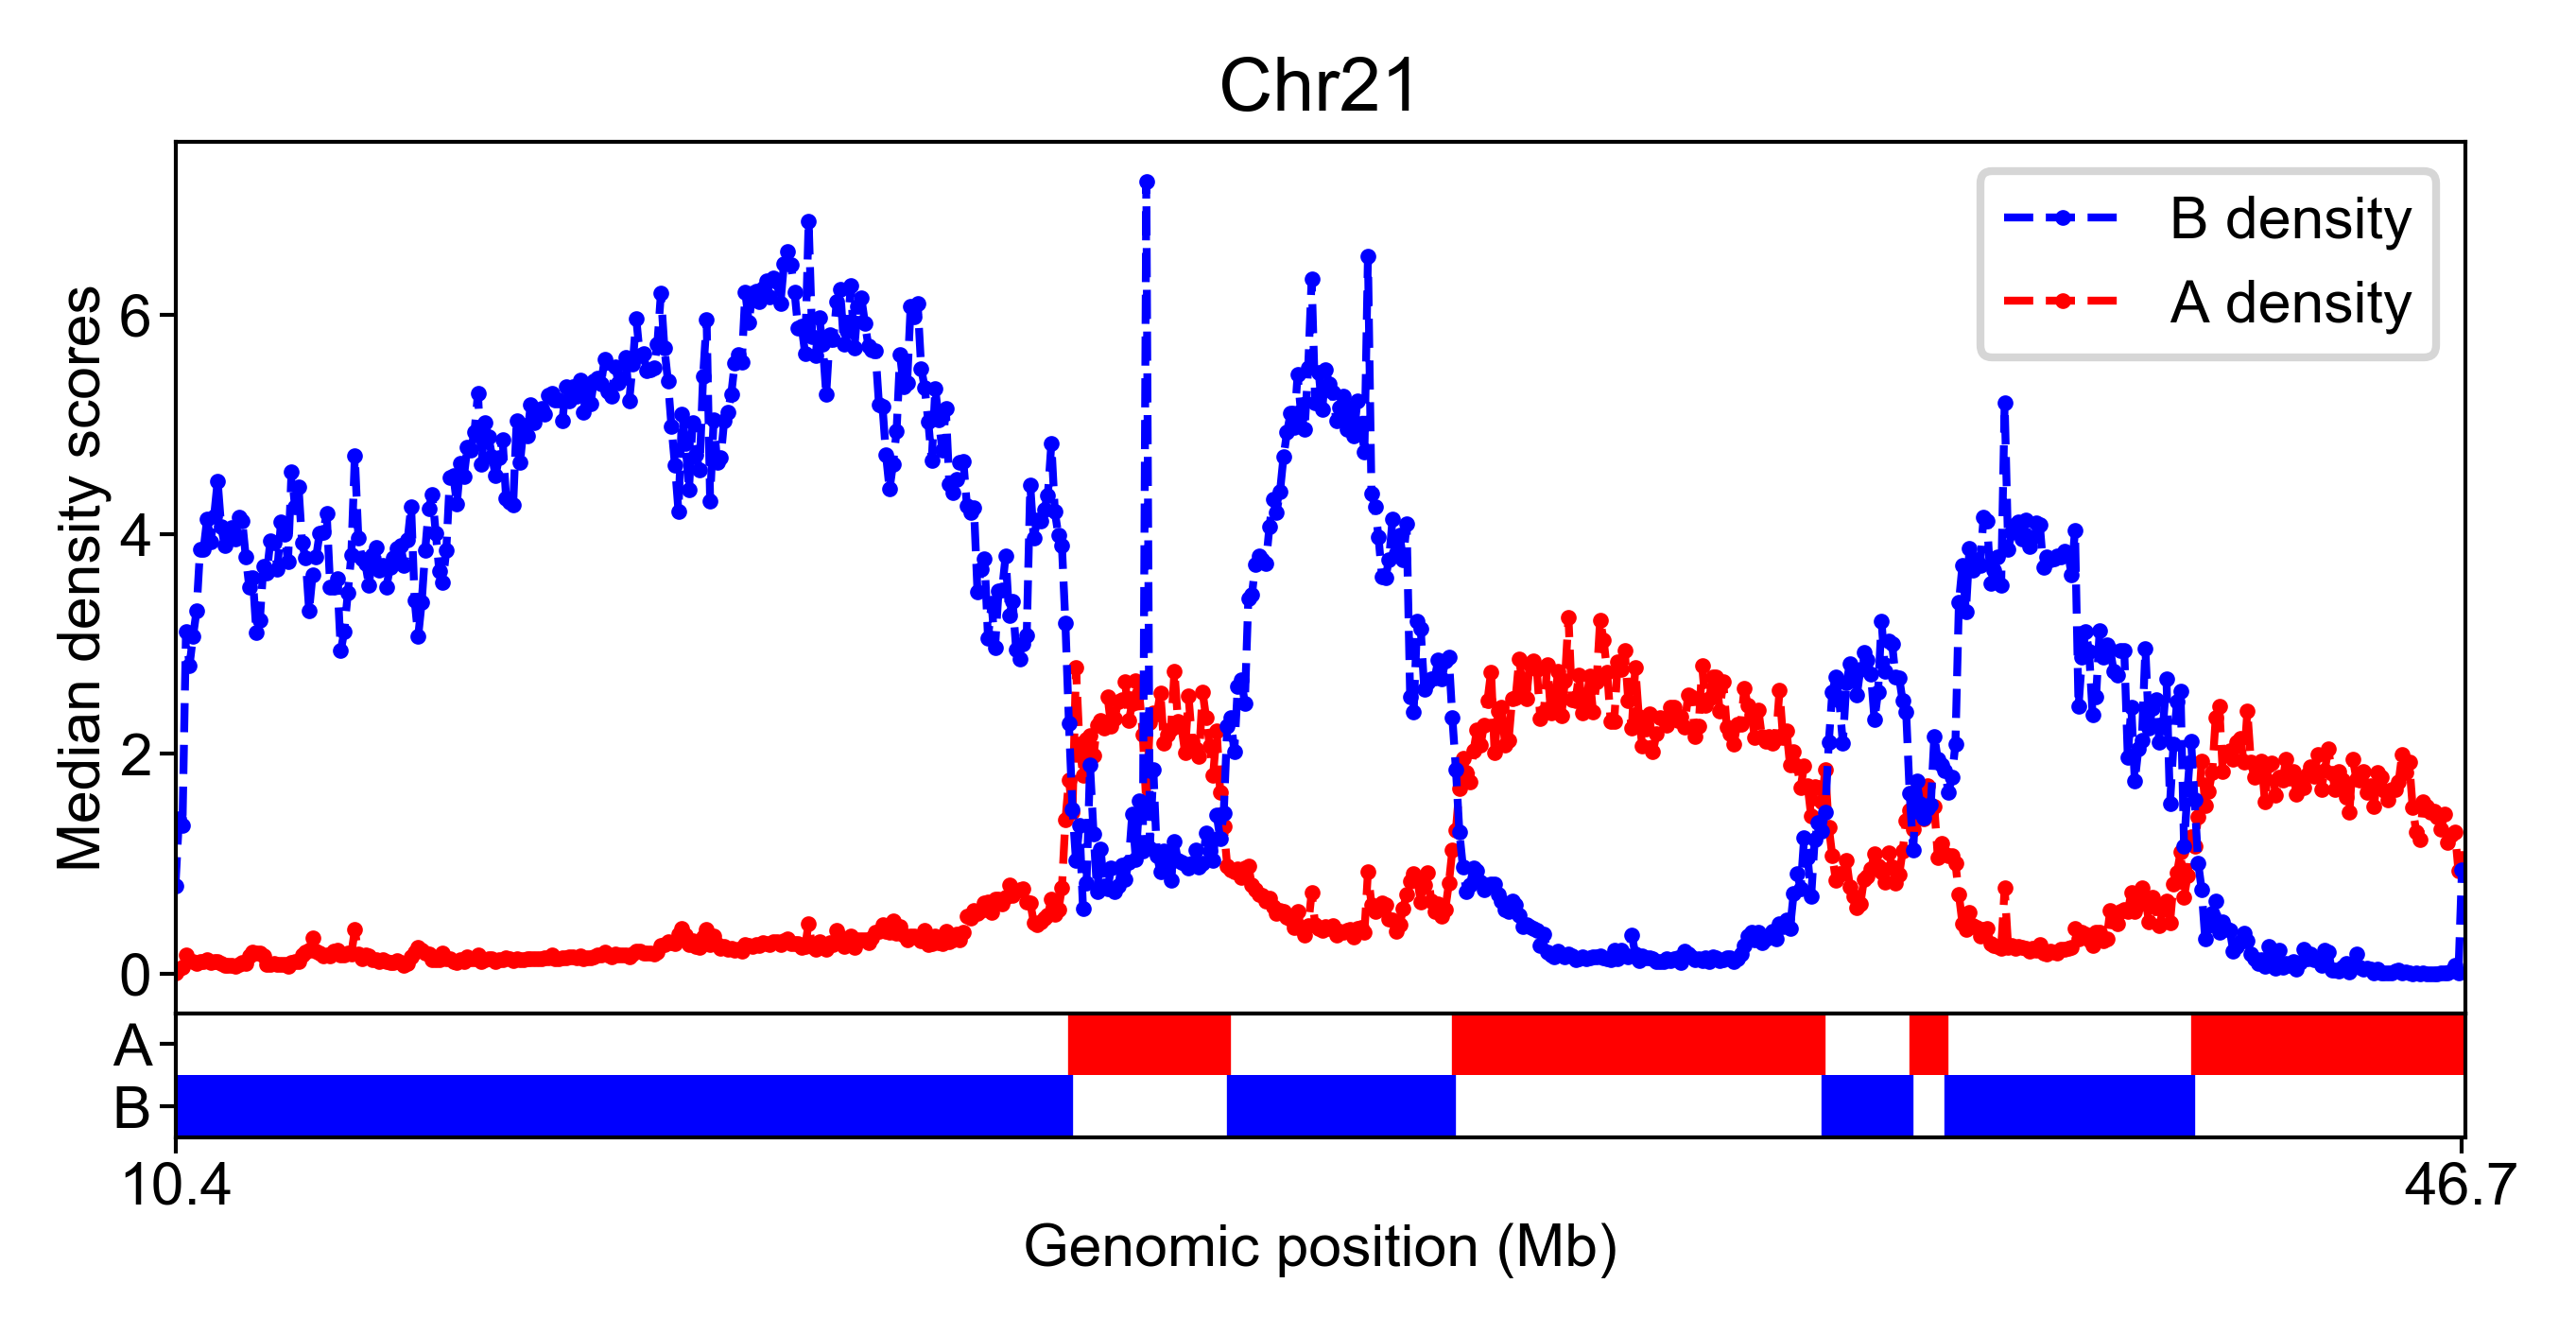

In [16]:
# Calculate mean A, B density
mean_A_scores = np.nanmedian([_s['A'] for _s in data_combined['dna_density_scores']], axis=0)
mean_B_scores = np.nanmedian([_s['B'] for _s in data_combined['dna_density_scores']], axis=0)

# Plot
fig = plt.figure(figsize=(_double_col_width, _single_col_width),dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[7,1], hspace=0., wspace=0.2)

main_ax = plt.subplot(grid[0], xticklabels=[])

main_ax.plot(mean_A_scores, 'r.--', label='A density', markersize=2, linewidth=1)
main_ax.plot(mean_B_scores, 'b.--', label='B density', markersize=2, linewidth=1)

# ticks
main_ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=False) # remove bottom ticklabels for ax1
main_ax.tick_params('x', length=0)
[i[1].set_linewidth(_ticklabel_width) for i in main_ax.spines.items()]
main_ax.set_ylabel(f"Median density scores", fontsize=_font_size, labelpad=1)

handles, labels = main_ax.get_legend_handles_labels()
main_ax.legend(handles[::-1], labels[::-1], fontsize=_font_size, loc='upper right')
main_ax.set_xlim(0,len(mean_A_scores))
main_ax.set_title('Chr21', fontsize=_font_size+2, pad=4)

comp_ax = plt.subplot(grid[1], xticklabels=[], sharex=main_ax)
comp_ax.eventplot([data_combined['AB_dict']['A'], data_combined['AB_dict']['B']], lineoffsets=[0.5,-0.5],linelengths=1, linewidths=1, 
                   colors=np.array([[1, 0, 0],[0, 0, 1]]))
#comp_ax.imshow(comp_vector[np.newaxis,:], cmap='seismic', vmin=-1, vmax=1)
comp_ax.tick_params('both', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in comp_ax.spines.items()]

comp_ax.set_yticks([0.5,-0.5])
comp_ax.set_yticklabels(["A","B"])
comp_ax.set_ylim([-1,1])
_xticks = [0, len(mean_A_scores)-1]
comp_ax.set_xticks(_xticks)
comp_ax.set_xticklabels(np.round(mid_positions_Mb[_xticks], 1))
comp_ax.set_xlabel(f'Genomic position (Mb)', fontsize=_font_size, labelpad=1)



plt.gcf().subplots_adjust(bottom=0.1, left=0.05)

plt.savefig(os.path.join(figure_folder, 'FigS2C_chr21_mean_AB_density_combined.pdf'), transparent=True)

plt.show()

<a id='3.3'></a>
## 3.3 visualize density in the example chromosome 

(FigS2B)

1058


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
E:\Users\puzheng\anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x0000024410031780>
-- save 3d-rendering into file:E:\Users\puzheng\Documents\2020_cell_figures\Chr21_compartment_figures\FigS2B1_3d_render_chr-1058_combined_AB-calling.pdf


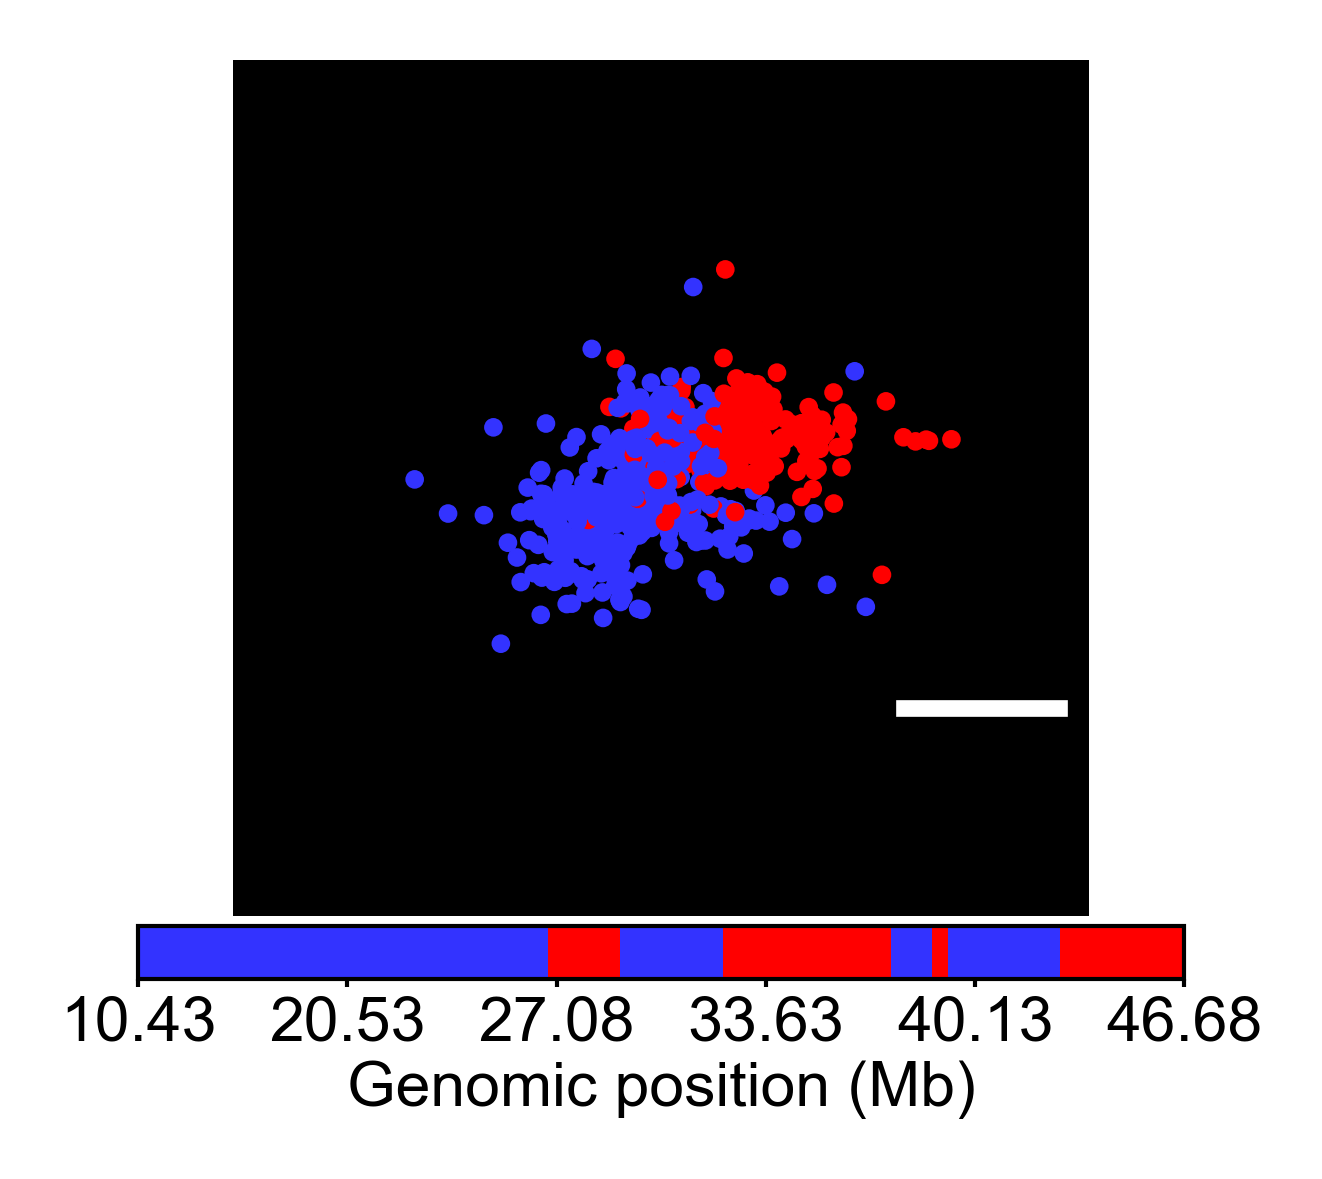

-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x0000024411D5BB00>
-- save 3d-rendering into file:E:\Users\puzheng\Documents\2020_cell_figures\Chr21_compartment_figures\FigS2B2_3d_render_chr-1058_combined_AB-ratio.pdf


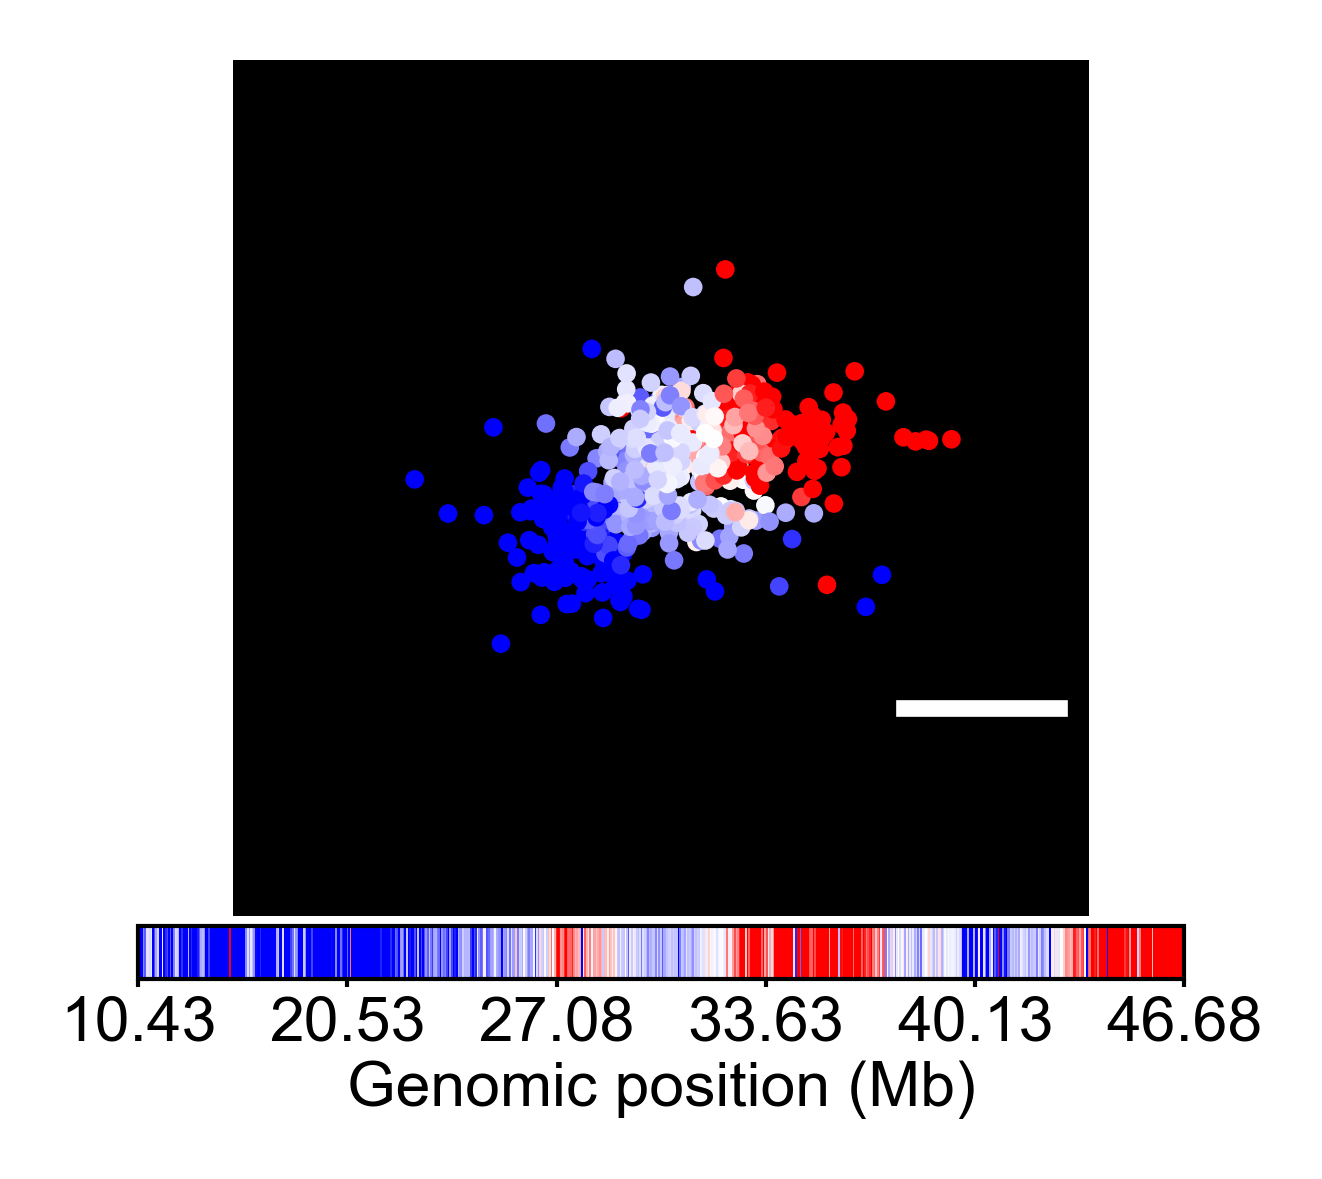

In [17]:
## prepare examples

# example chromosome id
example_id = 1058
#for example_id in np.arange(1037,1057):
dna_zxys = data_combined['dna_zxys'][example_id]
print(example_id)

# prepare AB score and log(A/B) ratio
ascores = data_combined['dna_density_scores'][example_id]['A']
bscores = data_combined['dna_density_scores'][example_id]['B']
abratios = np.log(ascores / bscores) - np.log(len(data_combined['AB_dict']['A'])/len(data_combined['AB_dict']['B']))
abratios = abratios / np.log(2)
def normalize_color(mat, vmin=None, vmax=None):
    _mat = np.array(mat).copy()
    if vmin is None:
        vmin = np.nanmin(_mat)
    if vmax is None:
        vmax = np.nanmax(_mat)
    # based on vmin vmax, do thresholding
    _mat[_mat < vmin] = vmin
    _mat[_mat > vmax] = vmax
    _mat = (_mat - np.nanmin(_mat)) / (np.nanmax(_mat) - np.nanmin(_mat))
    return _mat

## prepare colors
# compartment color cmap
comp_colors = []
for _i in np.arange(len(dna_zxys)):
    if _i in data_combined['AB_dict']['A']:
        comp_colors.append([1,0,0,1])
    elif _i in data_combined['AB_dict']['B']:
        comp_colors.append([0.2,0.2,1,1])
    else:
        raise ValueError
from matplotlib.colors import ListedColormap
comp_cmap = ListedColormap(comp_colors)

# ratio color map
ratio_cmap = matplotlib.cm.get_cmap('bwr')
color_limits = [-15, 15]
ratio_colors = np.array([np.array(ratio_cmap(_s)) 
                         for _s in normalize_color(abratios, 
                                                   vmin=min(color_limits),
                                                   vmax=max(color_limits))])
# plot AB calling
from source.figure_tools.image import chromosome_structure_3d_rendering
ax3d, cb = chromosome_structure_3d_rendering(dna_zxys, 
                                             cmap=comp_cmap, 
                                             image_radius=500,
                                             pca_align=False,
                                             marker_size=5, line_width=0.,
                                             marker_alpha=1, line_alpha=1,
                                             #view_azim_angle=180, view_elev_angle=90,
                                             cbar_tick_labels=data_combined['mid_position_Mb'],
                                             cbar_label='Genomic position (Mb)',
                                             cbar_shrink=1,
                                             save=True, save_folder=figure_folder, 
                                             save_basename=f'FigS2B1_3d_render_chr-{example_id}_combined_AB-calling.pdf')
plt.show()

# plot ratio
ax3d, cb = chromosome_structure_3d_rendering(dna_zxys, 
                                             cmap=ratio_colors, 
                                             image_radius=500,
                                             pca_align=False,
                                             marker_size=5, line_width=0.,
                                             marker_alpha=1, line_alpha=1,
                                             #view_azim_angle=180, view_elev_angle=90,
                                             cbar_tick_labels=data_combined['mid_position_Mb'],
                                             cbar_label='Genomic position (Mb)',
                                             cbar_shrink=1,
                                             save=True, save_folder=figure_folder, 
                                             save_basename=f'FigS2B2_3d_render_chr-{example_id}_combined_AB-ratio.pdf')
plt.show()


<a id='3.4'></a>
## 3.4 calculate segregation scores based on A,B density

(Fig2C)

In [18]:
def randomize_AB_dict(AB_dict):
    all_regs = np.sort(np.concatenate(list(AB_dict.values())))
    AB_identities = np.zeros(len(all_regs))
    AB_identities[np.array([_i for _i,_r in enumerate(all_regs) 
                            if _r in AB_dict['A']])] = 1
    # randomize new start
    new_start = np.random.randint(0, len(all_regs))
    new_AB_identities = np.concatenate([AB_identities[new_start:], AB_identities[:new_start]])
    # recreate AB_dict
    new_AB_dict = {'A': np.sort(all_regs[np.where(new_AB_identities==1)[0]]),
                   'B': np.sort(all_regs[np.where(new_AB_identities==0)[0]]),}
    return new_AB_dict

# calculate dynamic fraction scores
from scipy.stats import scoreatpercentile

In [19]:
AB_identities_combined = np.ones(len(data_combined['dna_zxys'][0])) * np.nan
AB_identities_combined[data_combined['AB_dict']['A']] = 1
AB_identities_combined[data_combined['AB_dict']['B']] = 0

# calculate re-thresholded fraction scores
A_fracs, B_fracs = [], []
A_ths, B_ths = [], []
cloud_th_per=67
for _sd in tqdm(data_combined['dna_density_scores']):
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][data_combined['AB_dict']['A']], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][data_combined['AB_dict']['B']], 100-cloud_th_per)
    # calculate purity within A,B clouds
    A_fracs.append(np.nanmean(AB_identities_combined[np.where(_sd['A'] >= _A_th)[0]]))
    B_fracs.append(1-np.nanmean(AB_identities_combined[np.where(_sd['B'] >= _B_th)[0]]))
    # store AB thresholds for references
    A_ths.append(_A_th)
    B_ths.append(_B_th)
# calculate re-thresholded fraction scores
rand_A_fracs, rand_B_fracs = [], []

for _sd in tqdm(data_combined['dna_density_scores']):
    # randomize AB dict
    _rand_AB_dict = randomize_AB_dict(data_combined['AB_dict'])
    _rand_A_inds, _rand_B_inds = np.array(_rand_AB_dict['A']), np.array(_rand_AB_dict['B'])
    # generate randomized AB_identities_combined vector for purity calculation
    _rand_AB_identities_combined = np.ones(len(data_combined['dna_zxys'][0])) * np.nan
    _rand_AB_identities_combined[_rand_AB_dict['A']] = 1
    _rand_AB_identities_combined[_rand_AB_dict['B']] = 0
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][_rand_A_inds], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][_rand_B_inds], 100-cloud_th_per)
    # calculate purity within A,B clouds
    rand_A_fracs.append(np.nanmean(_rand_AB_identities_combined[np.where(_sd['A'] >= _A_th)[0]]))
    rand_B_fracs.append(1-np.nanmean(_rand_AB_identities_combined[np.where(_sd['B'] >= _B_th)[0]]))

# Save
data_combined['segregation_scores'] = (np.array(A_fracs) + np.array(B_fracs)) / 2
data_combined['randomized_segregation_scores'] = (np.array(rand_A_fracs) + np.array(rand_B_fracs)) / 2

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


### segregation score histogram for Chr21

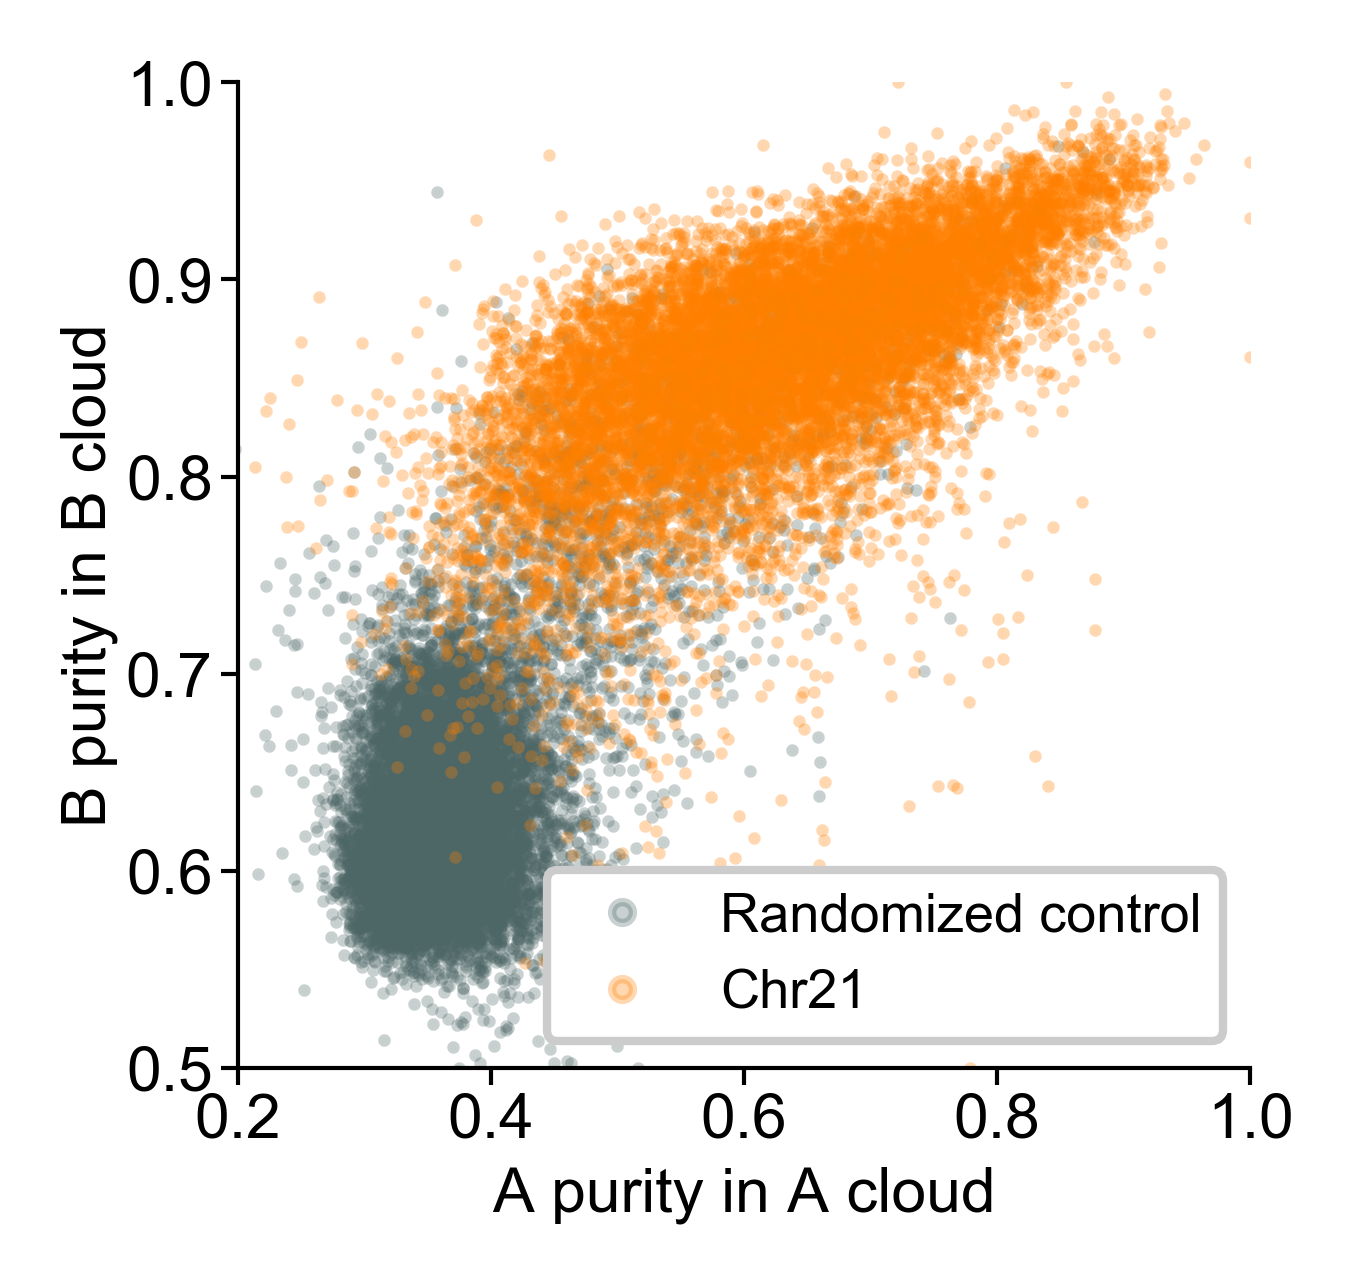

In [38]:
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

ax.plot(rand_A_fracs, rand_B_fracs, '.', label='Randomized control', 
        color=[0.3,0.4,0.4], alpha=0.3, markersize=1 )
ax.plot(A_fracs, B_fracs, '.', label='Chr21', 
        color=[1,0.5,0],alpha=0.3, markersize=1 )

plt.legend(fontsize=_font_size-1, loc='lower right', framealpha=1, markerscale=5,)

ax.tick_params('both', labelsize=_font_size, 
               width=_ticklabel_width, length=_ticklabel_size,
               pad=1, 
               #labelleft=False, labelbottom=False
               ) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0.2, 1])
ax.set_ylim([0.5, 1])
ax.set_xlabel(f'A purity in A cloud', fontsize=_font_size, labelpad=2)
ax.set_ylabel(f'B purity in B cloud', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

plt.savefig(os.path.join(figure_folder, f'chr21_fraction_score_scatter_th{cloud_th_per}.pdf'), transparent=True)

plt.show()

E:\Users\puzheng\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
E:\Users\puzheng\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


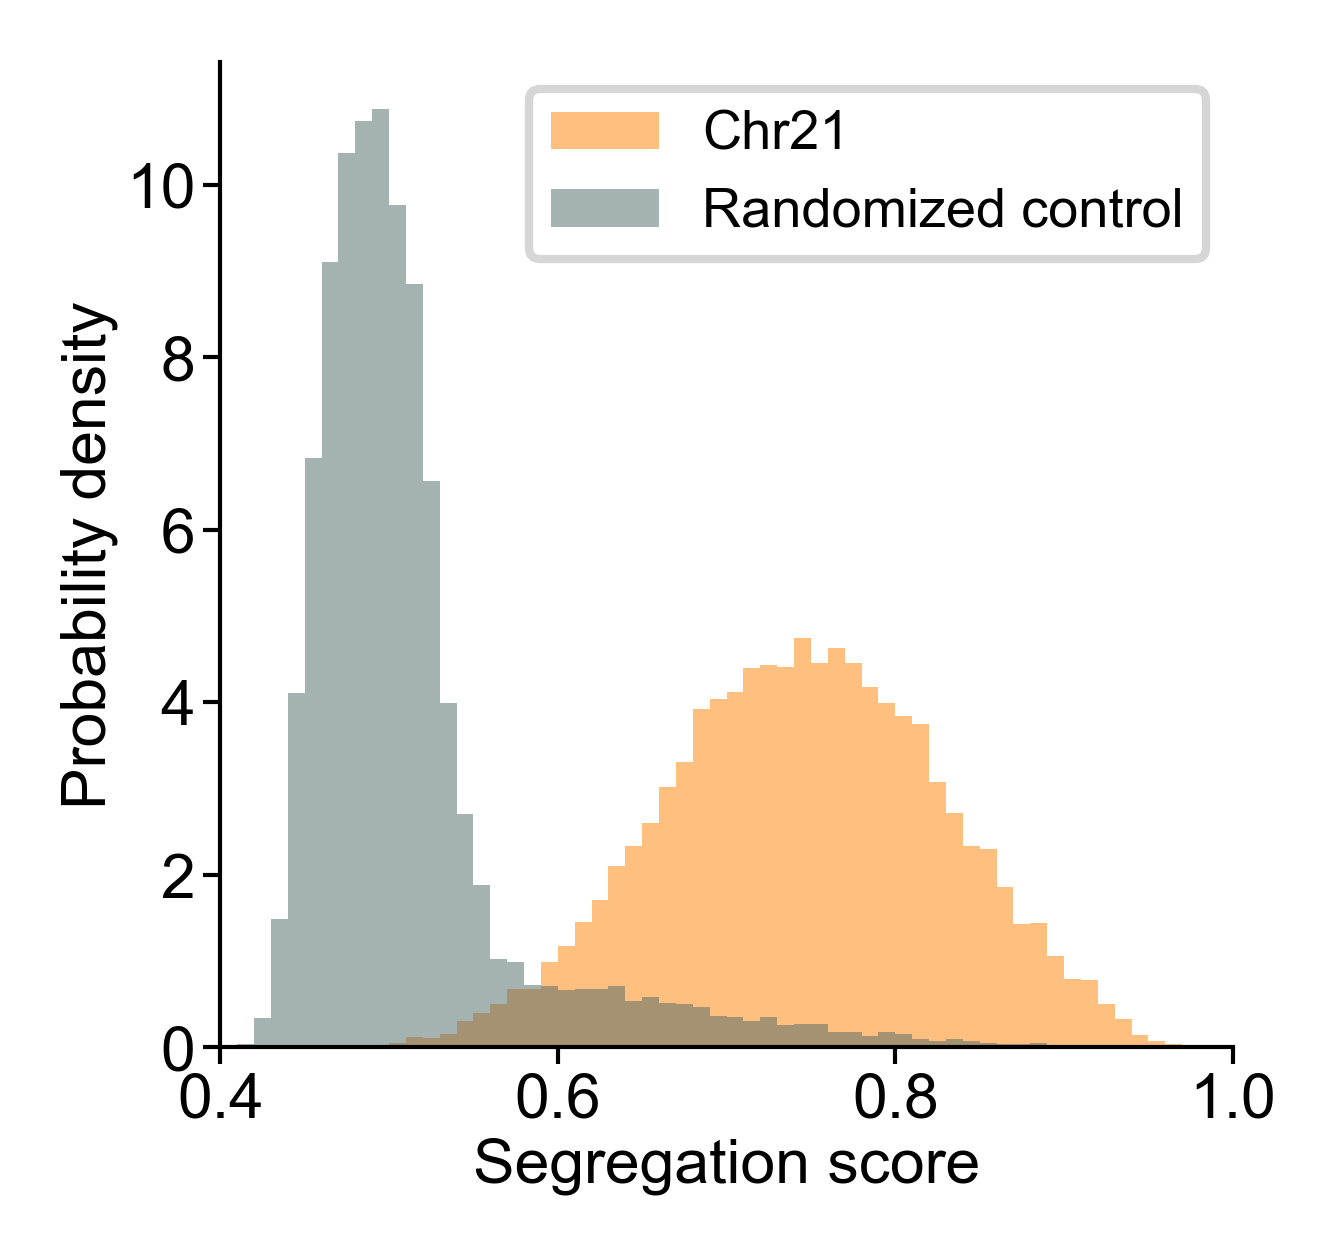

In [115]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)
ax.hist(data_combined['segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[1,0.5,0], label='Chr21')
ax.hist(data_combined['randomized_segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[0.3,0.4,0.4], label='Randomized control')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("Segregation score", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0.4,1])

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, 'Fig2C_chr21_segregation_hist_combined.pdf'), transparent=True)
plt.show()

<a id='3.5'></a>
## 3.5 A/B density ratio difference w/wo transcription

(Fig2H)

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


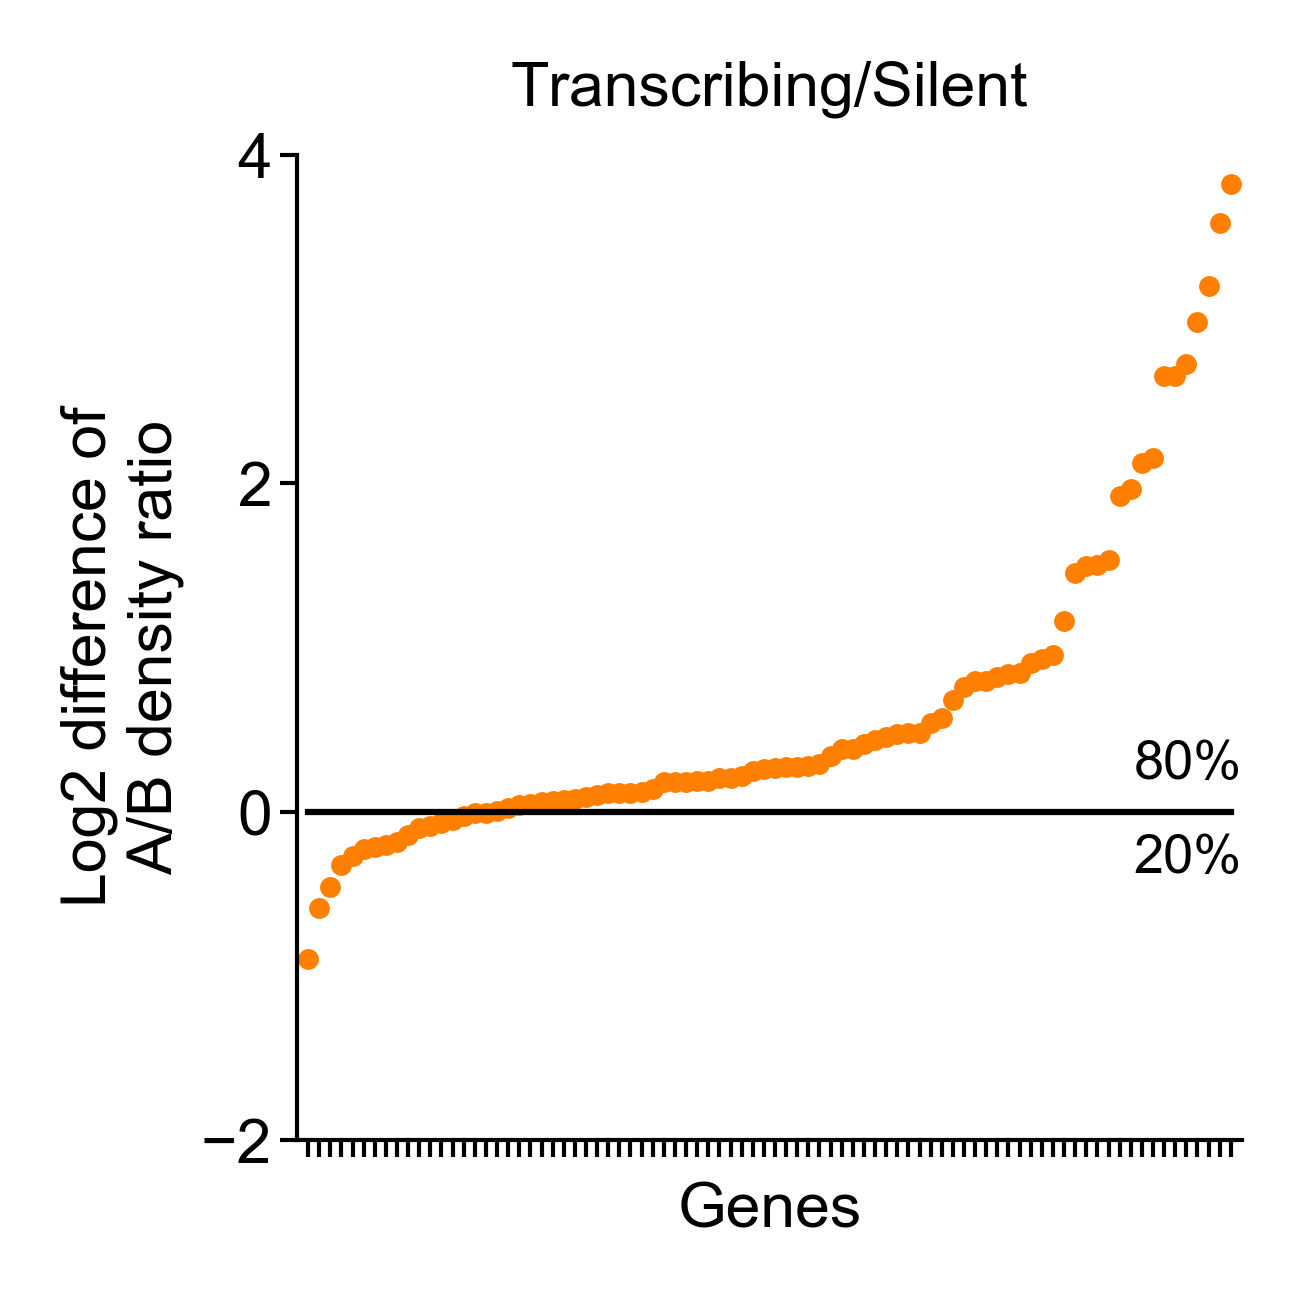

In [181]:
gene_density_dicts = data_combined['gene_density_scores']
gene_A_scores = np.array([_gsd['A'] for _gsd in gene_density_dicts])
gene_B_scores = np.array([_gsd['B'] for _gsd in gene_density_dicts])

trans_pfs = np.array(data_combined['trans_pfs'])

on_gene_AB_ratio, off_gene_AB_ratio = [], []
on_gene_total_density = []
off_gene_total_density = []

for _gind in range(gene_A_scores.shape[1]):
    # extract AB and transcription
    _a_scores = gene_A_scores[:, _gind]
    _b_scores = gene_B_scores[:, _gind]
    _transcriptions = trans_pfs[:,_gind]
    # get AB ratio
    _log_ab_ratios = np.log(_a_scores)/np.log(2) - np.log(_b_scores)/np.log(2)
    _total_density =  _a_scores+_b_scores
    # append
    on_gene_AB_ratio.append(np.nanmedian(_log_ab_ratios[_transcriptions & (np.isinf(_log_ab_ratios)==False)]))
    off_gene_AB_ratio.append(np.nanmedian(_log_ab_ratios[~_transcriptions & (np.isinf(_log_ab_ratios)==False)]))
    on_gene_total_density.append(np.nanmedian(_total_density[_transcriptions & (np.isinf(_total_density)==False)]))
    off_gene_total_density.append(np.nanmedian(_total_density[~_transcriptions & (np.isinf(_total_density)==False)]))


# convert into arrays
on_gene_AB_ratio = np.array(on_gene_AB_ratio)
off_gene_AB_ratio = np.array(off_gene_AB_ratio)
on_gene_total_density = np.array(on_gene_total_density)
off_gene_total_density = np.array(off_gene_total_density)

gene_ratio_diff = on_gene_AB_ratio - off_gene_AB_ratio

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

ax.plot(np.sort(gene_ratio_diff), '.', color=[1,0.5,0], label='All genes', markersize=3)
ax.plot(np.zeros(len(gene_ratio_diff)), 'black', label='ref', linewidth=0.75)

ax.tick_params('both', labelsize=_font_size, width=_ticklabel_width, length=_ticklabel_size, pad=1) 
        
        # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticks(np.arange(len(gene_ratio_diff)))
ax.set_yticks(np.arange(-6,6,2))
ax.set_xticklabels([])
ax.set_xlabel('Genes', fontsize=_font_size, labelpad=2)
ax.set_ylabel('Log2 difference of \nA/B density ratio', fontsize=_font_size, labelpad=2)
ax.set_xlim([-1, len(gene_ratio_diff)])
ax.set_ylim([-2,4])

#ax.legend(fontsize=_font_size, framealpha=1, loc='upper left')
ax.text(len(gene_ratio_diff), max(ax.get_ylim())/30, f'{np.round(np.mean(gene_ratio_diff>0),2)*100:.0f}%', 
        fontsize=_font_size-1, verticalalignment='bottom', horizontalalignment='right',)
ax.text(len(gene_ratio_diff), -max(ax.get_ylim())/30, f'{np.round(np.mean(gene_ratio_diff<0),2)*100:.0f}%', 
        fontsize=_font_size-1, verticalalignment='top', horizontalalignment='right',)

ax.set_title("Transcribing/Silent", fontsize=_font_size)
plt.gcf().subplots_adjust(left=0.2, bottom=0.15)

plt.savefig(os.path.join(figure_folder, 'Fig2H_diff_abratio_w-wo_transcribe_combined.pdf'), transparent=True)

plt.show()

<a id='3.6'></a>
## 3.6 firing rate difference with high/low A/B density ratio

(Fig2I)

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in true_divide
  if sys.path[0] == '':


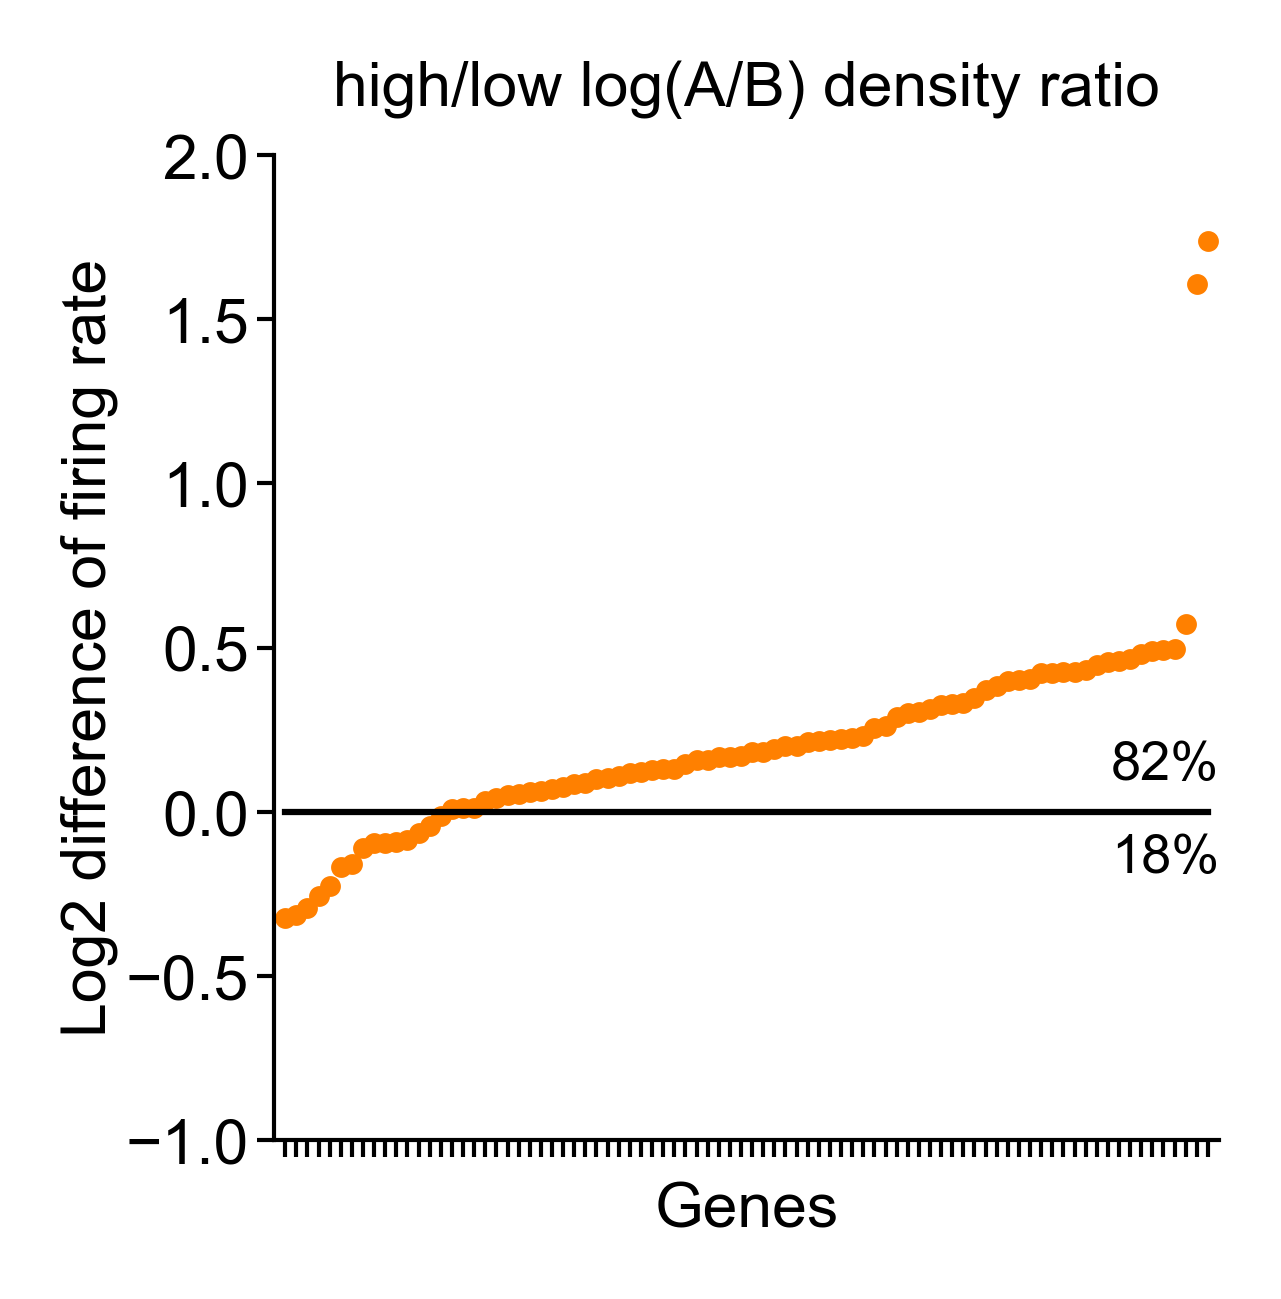

In [182]:
gene_density_dicts = data_combined['gene_density_scores']
gene_A_scores = np.array([_gsd['A'] for _gsd in gene_density_dicts])
gene_B_scores = np.array([_gsd['B'] for _gsd in gene_density_dicts])

trans_pfs = np.array(data_combined['trans_pfs'])

abratio_ratio = []
for _gid in np.arange(trans_pfs.shape[1]):
    # extract info
    _ga = gene_A_scores[:,_gid]
    _gb = gene_B_scores[:,_gid]
    _gratio = np.log(_ga / _gb) 
    
    # sel_inds
    _inds = np.argsort(_gratio)
    _sel_v = np.where((np.isnan(_gratio)==False) * (np.isinf(_gratio)==False))[0]
    _sel_inds = np.array([_i for _i in _inds if _i in _sel_v], dtype=np.int)
    
    _li = _sel_inds[:int(len(_sel_inds)/4)]
    _hi = _sel_inds[-int(len(_sel_inds)/4):]
    #print(len(_sel_inds), np.mean(_gratio[_li]), np.mean(_gratio[_hi]))
    _lfr = np.nanmean(trans_pfs[_li, _gid])
    _hfr = np.nanmean(trans_pfs[_hi, _gid])
    abratio_ratio.append(_hfr / _lfr)

abratio_fr_ratio = np.log(np.array(abratio_ratio)) / np.log(2)

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

#ax.plot(np.arange(len(sel_A_gene_inds)), 
#        np.sort(np.log(abratio_ratio[sel_A_gene_inds])), 
#        'r.', label='A genes', markersize=3)
#ax.plot(np.arange(len(sel_A_gene_inds),len(sel_A_gene_inds)+len(sel_B_gene_inds)), 
#         np.sort(np.log(abratio_ratio[sel_B_gene_inds])), 
#        'b.', label='B genes', markersize=3)

ax.plot(np.sort(abratio_fr_ratio), 
        '.', color=[1,0.5,0], label='All genes', markersize=3)
ax.plot(np.zeros(len(abratio_fr_ratio)), 
        'black', label='reference', linewidth=0.75)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1) # remove bottom ticklabels for ax1
ax.set_xticks(np.arange(len(abratio_fr_ratio)))
ax.set_xticklabels([])
ax.set_ylabel('Log odds ratio', fontsize=_font_size, labelpad=1)
ax.set_xlim([-1, len(abratio_fr_ratio)])
ax.set_ylim([-1,2])

[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('Genes', fontsize=_font_size, labelpad=2)
ax.set_ylabel('Log2 difference of firing rate', fontsize=_font_size, labelpad=1)
ax.set_title(f"high/low log(A/B) density ratio", 
             fontsize=_font_size)

#ax.legend(fontsize=_font_size, framealpha=1, loc='upper left')

ax.text(len(abratio_fr_ratio), max(ax.get_ylim())/30, f'{np.round(np.mean(abratio_fr_ratio>0),2)*100:.0f}%', 
        fontsize=_font_size-1, verticalalignment='bottom', horizontalalignment='right',)
ax.text(len(abratio_fr_ratio), -max(ax.get_ylim())/30, f'{np.round(np.mean(abratio_fr_ratio<=0),2)*100:.0f}%', 
        fontsize=_font_size-1, verticalalignment='top', horizontalalignment='right',)

plt.gcf().subplots_adjust(left=0.2, bottom=0.15)

plt.savefig(os.path.join(figure_folder, f"Fig2I_firing-rate_diff_w_high-low_abratio_combined.pdf"), transparent=True)

plt.show()

<a id='4'></a>
# 4. Characterization of compartments in G1, G2/S cells

This is specifically in replicate 2 because only this sample has geminin immunofluorescence labelling

<a id='4.1'></a>
## 4.1 calculate A,B density scores for replicate 2

In [26]:
import multiprocessing as mp
import time
num_threads=32
density_var = 108 # nm

# density score for 50kb genomic regions
_dna_density_args = [(_zxys,_zxys, data_combined['AB_dict'], [density_var,density_var,density_var], True) 
                     for _zxys in data_rep2['dna_zxys']]
_dna_density_time = time.time()

print(f"Multiprocessing calculate dna_density_scores", end=' ')
if 'dna_density_scores' not in data_rep2:
    with mp.Pool(num_threads) as dna_density_pool:
        dna_density_dicts = dna_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _dna_density_args)
        dna_density_pool.close()
        dna_density_pool.join()
        dna_density_pool.terminate()
    # save
    data_rep2['dna_density_scores'] = dna_density_dicts
print(f"in {time.time()-_dna_density_time:.3f}s.")

Multiprocessing calculate dna_density_scores in 26.692s.


<a id='4.2'></a>
## 4.2 calculate segregation scores for G1,G2/S chromosomes

(FigS2D)

In [27]:
def randomize_AB_dict(AB_dict):
    all_regs = np.sort(np.concatenate(list(AB_dict.values())))
    AB_identities = np.zeros(len(all_regs))
    AB_identities[np.array([_i for _i,_r in enumerate(all_regs) 
                            if _r in AB_dict['A']])] = 1
    # randomize new start
    new_start = np.random.randint(0, len(all_regs))
    new_AB_identities = np.concatenate([AB_identities[new_start:], AB_identities[:new_start]])
    # recreate AB_dict
    new_AB_dict = {'A': np.sort(all_regs[np.where(new_AB_identities==1)[0]]),
                   'B': np.sort(all_regs[np.where(new_AB_identities==0)[0]]),}
    return new_AB_dict

# calculate dynamic fraction scores
from scipy.stats import scoreatpercentile

AB_identities_rep2 = np.ones(len(data_rep2['dna_zxys'][0])) * np.nan
AB_identities_rep2[data_combined['AB_dict']['A']] = 1
AB_identities_rep2[data_combined['AB_dict']['B']] = 0

# calculate re-thresholded fraction scores
A_fracs, B_fracs = [], []
A_ths, B_ths = [], []
cloud_th_per=67
for _sd in tqdm(data_rep2['dna_density_scores']):
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][data_combined['AB_dict']['A']], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][data_combined['AB_dict']['B']], 100-cloud_th_per)
    # calculate purity within A,B clouds
    A_fracs.append(np.nanmean(AB_identities_rep2[np.where(_sd['A'] >= _A_th)[0]]))
    B_fracs.append(1-np.nanmean(AB_identities_rep2[np.where(_sd['B'] >= _B_th)[0]]))
    # store AB thresholds for references
    A_ths.append(_A_th)
    B_ths.append(_B_th)
# calculate re-thresholded fraction scores
rand_A_fracs, rand_B_fracs = [], []

for _sd in tqdm(data_rep2['dna_density_scores']):
    # randomize AB dict
    _rand_AB_dict = randomize_AB_dict(data_combined['AB_dict'])
    _rand_A_inds, _rand_B_inds = np.array(_rand_AB_dict['A']), np.array(_rand_AB_dict['B'])
    # generate randomized AB_identities_rep2 vector for purity calculation
    _rand_AB_identities_rep2 = np.ones(len(data_rep2['dna_zxys'][0])) * np.nan
    _rand_AB_identities_rep2[_rand_AB_dict['A']] = 1
    _rand_AB_identities_rep2[_rand_AB_dict['B']] = 0
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][_rand_A_inds], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][_rand_B_inds], 100-cloud_th_per)
    # calculate purity within A,B clouds
    rand_A_fracs.append(np.nanmean(_rand_AB_identities_rep2[np.where(_sd['A'] >= _A_th)[0]]))
    rand_B_fracs.append(1-np.nanmean(_rand_AB_identities_rep2[np.where(_sd['B'] >= _B_th)[0]]))

# Save
data_rep2['segregation_scores'] = (np.array(A_fracs) + np.array(B_fracs)) / 2
data_rep2['randomized_segregation_scores'] = (np.array(rand_A_fracs) + np.array(rand_B_fracs)) / 2

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice


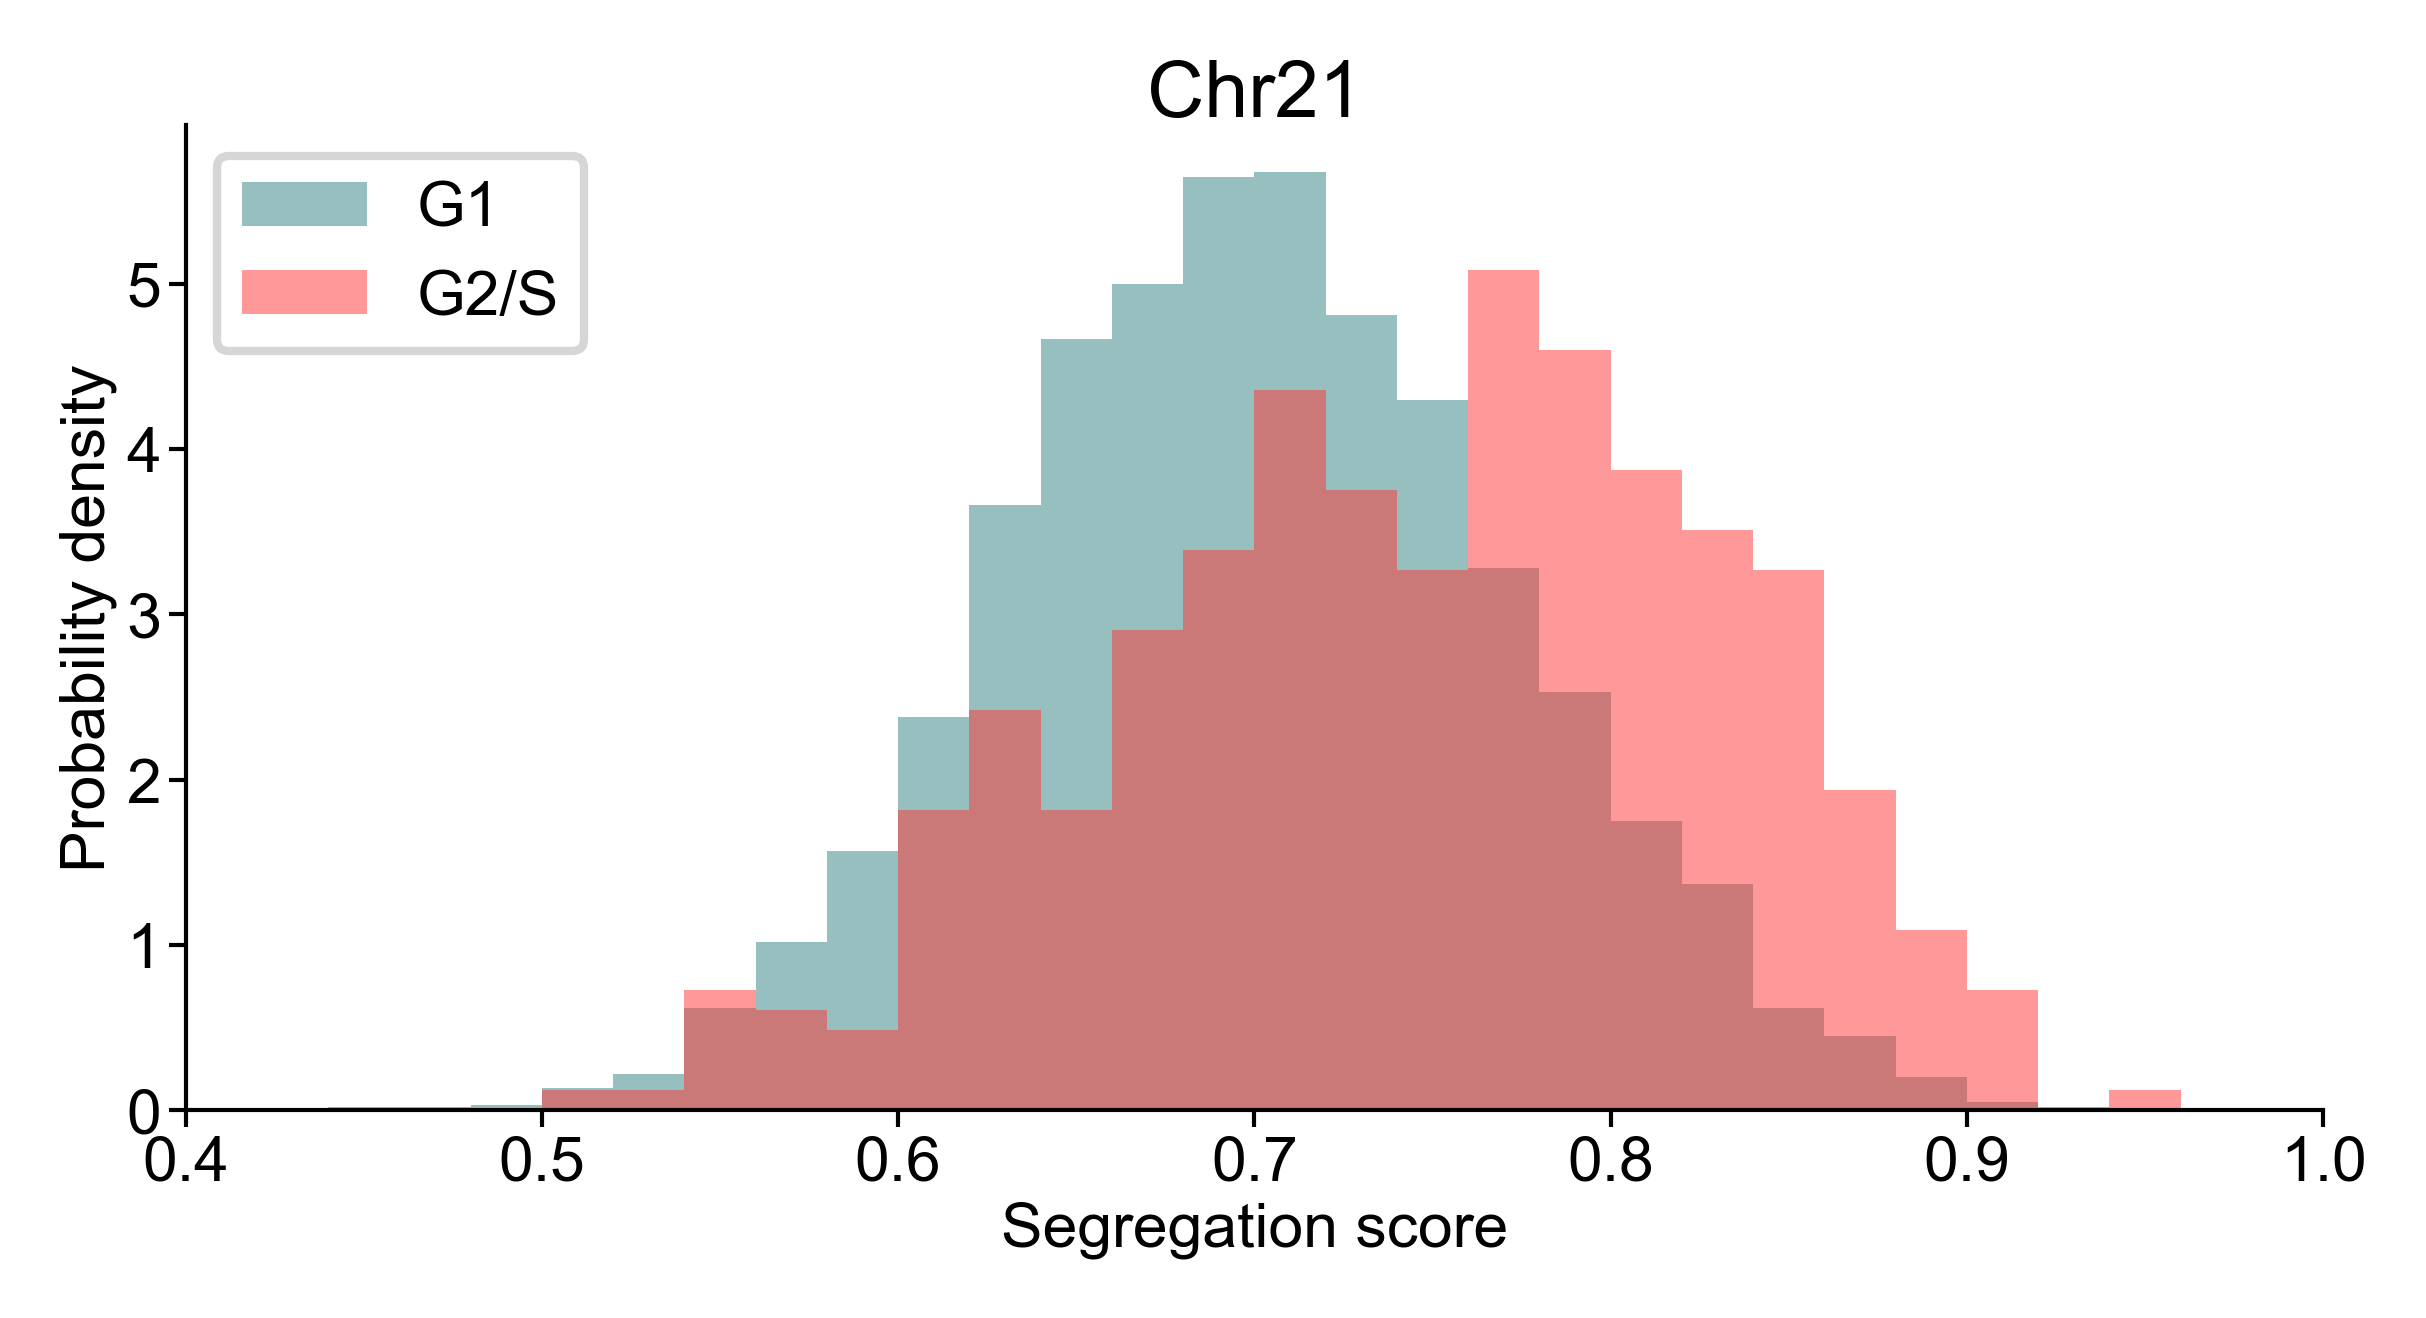

In [36]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width),dpi=600)

ax.hist(np.array(data_rep2['segregation_scores'])[np.array(data_rep2['G1_flags'])], 50, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[0.2,0.5,0.5], label='G1')
ax.hist(np.array(data_rep2['segregation_scores'])[np.array(data_rep2['G2/S_flags'])], 50, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[1,0.2,0.2], label='G2/S')

ax.legend(fontsize=_font_size, loc='upper left')

ax.set_xlabel("Segregation score", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0.4,1])
ax.set_title('Chr21', fontsize=_font_size+2, pad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

plt.savefig(os.path.join(figure_folder, f'FigS2D_chr21_segregation_scores_G1-G2S_rep2.pdf'), transparent=True)
plt.show()